In [1652]:
# Some extra imports that will be required later
!pip install xgboost

# Importing Libaries

In [1653]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
from datetime import timedelta

# Libraries for model building
from sklearn.linear_model       import LogisticRegression 
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.svm                import SVC
from sklearn.tree               import DecisionTreeClassifier
from xgboost                    import XGBClassifier
from sklearn.neural_network     import MLPClassifier

from sklearn.pipeline           import Pipeline
from sklearn.preprocessing      import StandardScaler

from scipy.stats.mstats         import winsorize
from scipy.stats                import randint, uniform
from sklearn.model_selection    import RandomizedSearchCV, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics            import roc_auc_score, roc_curve, confusion_matrix, classification_report, auc

import warnings
warnings.filterwarnings('ignore')

# Importing data

In [1654]:
# Importing data

camp = pd.read_csv('../data/raw/campaigns.csv', sep=';')
donors = pd.read_csv('../data/raw/donors.csv', sep=',')
gifts = pd.read_csv('../data/raw/gifts.csv', sep=',')
sc6 = pd.read_csv('../data/raw/selection campaign 6169.csv')
sc7 = pd.read_csv('../data/raw/selection campaign 7244.csv')
test = pd.read_csv('../data/raw/selection campaign 7362.csv')

In [1655]:
# Basic exploration 
print('Donors shape:', donors.shape) 
print('Gifts shape:', gifts.shape) 
print('Campaign 6169 shape:', sc6.shape) 
print('Campaign 7244 shape:', sc7.shape)
print('Campaign 7362 shape:', test.shape)

Donors shape: (44691, 7)
Gifts shape: (216594, 4)
Campaign 6169 shape: (34888, 1)
Campaign 7244 shape: (25645, 1)
Campaign 7362 shape: (26522, 1)


# References

This section aims to display some core elements in the code for them to be centralized and easier to manipulate when changing some aspects of the code.

This is particularly relevant in the context of model building since it allows to test combinations and improve them.

In [1656]:
rd1 = pd.to_datetime('2018-09-04') # date of 6169 campaign
rd2 = pd.to_datetime('2019-06-18') # date of 7244 campaign
rd3 = pd.to_datetime('2020-02-01') # date of the 7362 campain
look_back = 6575 # time window for independent variables --> 18 years of data here (6575 days)
donation = 30 # the donnation level for targets (amount targetted among the donnors to consider them in the model)

# I/ Data description + Cleaning

--> Before building any machine learning model, it is essential to clean the data to ensure that the inputs are accurate and consistent. 

--> Cleaning the data first prevents missing values, outliers, and duplicated records from contaminating or distorting the features you later create. 

--> If we performed feature engineering on unclean data, any errors in the raw variables would become amplified in the new features. 

--> By cleaning the dataset first, we guarantee that engineered features truly represent meaningful patterns in the data. 

--> This leads to more stable models, better performance, and more reliable predictions.

## 1) Campaign

### General inspection

In [1657]:
# Displaying the campaign table
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [1658]:
# Displaying information
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


### Missing values and outliers

In [1659]:
# Convert date to datetime
camp['date'] = pd.to_datetime(camp['date'])

In [1660]:
camp.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6 873,"0,17 €"
1,154,2005-01-01,7 656,"0,30 €"
2,180,2005-01-18,9 933,"0,20 €"
3,433,2005-01-29,7 448,"0,59 €"
4,476,2005-02-12,6 605,"0,51 €"


In [1661]:
# Convert the letterSent and cost per unit to a number
# To find outliers, we need to convert columns to integer before
# We use a raw string character that will find all types of whitespaces not just blanks
camp['lettersSent'] = (
    camp['lettersSent']
        .astype(str)
        .str.replace(r'\D+', '', regex=True)
        .astype(int)
)

camp['CostUnit'] = (
    camp['CostUnit']
        .astype(str)
        .str.replace(r'[^0-9,.-]', '', regex=True)
        .str.replace(',', '.', regex=False)
        .astype(float)
)
camp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   campaignID   367 non-null    int64         
 1   date         367 non-null    datetime64[ns]
 2   lettersSent  367 non-null    int64         
 3   CostUnit     367 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 11.6 KB


In [1662]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(camp.isna().sum())
print('---------------------------------')
print(f'The data shows {camp.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
campaignID     0
date           0
lettersSent    0
CostUnit       0
dtype: int64
---------------------------------
The data shows 0 missing values


In [1663]:
# Finding outliers (using only the numerical columns)
num_cols = camp.select_dtypes(include=['float', 'int']).columns.drop('campaignID')
# We define our boundaries
lower = camp[num_cols].quantile(0.01)
upper = camp[num_cols].quantile(0.99)

# printing the results
print('Lower bounds:\n',lower)
print('-------------------------')
print('Upper bounds:\n', upper)

Lower bounds:
 lettersSent    5243.66
CostUnit          0.02
Name: 0.01, dtype: float64
-------------------------
Upper bounds:
 lettersSent    47746.96
CostUnit           0.61
Name: 0.99, dtype: float64


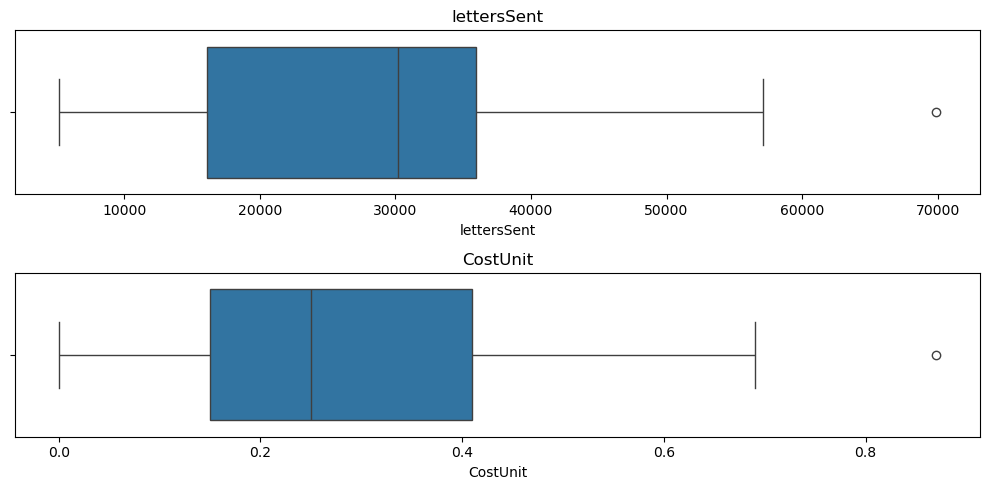

In [1664]:
# Verifying outliers
# We use boxplots to identify potential outliers

fig, ax = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10, 5))

for i, col in enumerate(num_cols):
    sns.boxplot(ax=ax[i], x=camp[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [1665]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
camp = camp.copy()
camp[num_cols] = camp[num_cols].clip(lower=lower, upper=upper, axis=1)

In [1666]:
# Verifying winsorization worked
for col in num_cols:
    print(col, 'min :', round(camp[col].min(),2))
    print(col, 'max :', round(camp[col].max(),2))

lettersSent min : 5243.66
lettersSent max : 47746.96
CostUnit min : 0.02
CostUnit max : 0.61


In [1667]:
camp.head(2)

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873.0,0.17
1,154,2005-01-01,7656.0,0.30


## 2) Donors

### General inspection

In [1668]:
# Displaying the donors table
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,D100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,D100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,D100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [1669]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  object 
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


### Missing values and outliers

In [1670]:
# Convert date to datetime
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

In [1671]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(donors.isna().sum())
print('---------------------------------')
print(f'The data shows {donors.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64
---------------------------------
The data shows 34 missing values


In [1672]:
# Handling missing values

# zipcode
donors = donors.dropna(subset=['zipcode']) # since it represents only two observation and there is no other logical way to inpute them

# gender
gender_mode = donors['gender'].mode()[0]
donors['gender'] = donors['gender'].fillna(value=gender_mode) #filling by the mode seems relevant for this amount of data (32 out of 44 689 clients)

print(f'The data shows {donors.isna().sum().sum()} missing values now')

The data shows 0 missing values now


In [1673]:
# Checking that there are indeed 44 689 different clients
print('Donors shape:', donors.shape)

Donors shape: (44689, 7)


In [1674]:
# Zipcode was imported as float (e.g., 1180.0), but zipcodes are categorical labels
# We convert to integer to remove decimals, then to string so models don't treat it as numeric (which can mislead models)
donors['zipcode'] = donors['zipcode'].astype('Int64').astype(str)

In [1675]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   donorID      44689 non-null  object        
 1   zipcode      44689 non-null  object        
 2   province     44689 non-null  object        
 3   region       44689 non-null  object        
 4   gender       44689 non-null  object        
 5   language     44689 non-null  object        
 6   dateOfBirth  44689 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 2.7+ MB


In [1676]:
donors.head(2)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14


## 3) Gifts

### General inspection

In [1677]:
# Displaying the gifts table
gifts.head()

,donorID,campaignID,amount,date
0,D100001,NaN,"12,39",23/03/2004
1,D100001,1577.0,"12,39",11/10/2007
2,D100001,1634.0,"6,69",28/12/2007
3,D100001,1778.0,"24,79",14/06/2008
4,D100001,1808.0,"7,44",09/07/2008


In [1678]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  object 
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.6+ MB


### Missing values and outliers

In [1679]:
# Convert date to datetime
gifts['date'] = pd.to_datetime(gifts['date'])

# Be more specific
gifts = gifts.rename(columns={'date' : 'gift_date'})

In [1680]:
# Convert amount to numeric
gifts['amount'] = (
    gifts['amount']
    .astype(str)
    .str.replace(".", "", regex=False)   # remove thousand separators
    .str.replace(",", ".", regex=False)  # convert decimal comma → dot
)
gifts['amount'] = pd.to_numeric(gifts['amount'], errors='coerce')



In [1681]:
gifts.head()

,donorID,campaignID,amount,gift_date
0,D100001,NaN,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28
3,D100001,1778.0,24.79,2008-06-14
4,D100001,1808.0,7.44,2008-07-09


In [1682]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(gifts.isna().sum())
print('---------------------------------')
print(f'The data shows {gifts.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID           0
campaignID    15637
amount           23
gift_date         0
dtype: int64
---------------------------------
The data shows 15660 missing values


In [1683]:
gifts.campaignID = gifts.campaignID.fillna(value=0)
print(f'The data shows {gifts.isna().sum().sum()} missing values at this stage')

The data shows 23 missing values at this stage


Handling the missing ID's : 
- A missing ID means that a donation was NOT part of any campaign - it was a spontaneous donation
- This gives a valuable information and could be very useful for our models 
- Thus, we should keep them as they are
- We inputed by 0 the campaignID because later, during the feature engineering, when we will add features about the campaign, we will need to merge using the campaignID key. This would not be possible if we had missing values.

In [1684]:
# Visualizing the highest amount donation
gifts.sort_values(by = 'amount', ascending=False).head()

,donorID,campaignID,amount,gift_date
153012,D123168,0.0,4000000.00,2010-04-26
141895,D120861,1917.0,2479000.00,2008-11-17
150654,D122679,2417.0,30000.00,2010-07-04
182959,D130966,1377.0,12394.68,2007-04-21
21410,D102552,3785.0,5000.00,2014-05-03


In [1685]:
# Inputing the amounts (by the median)
amount_median = gifts.amount.median()

gifts.amount = gifts.amount.fillna(amount_median)

print(f'There are {gifts.isna().sum().sum()} at this stage in the gift table after NaNs handling.')

There are 0 at this stage in the gift table after NaNs handling.


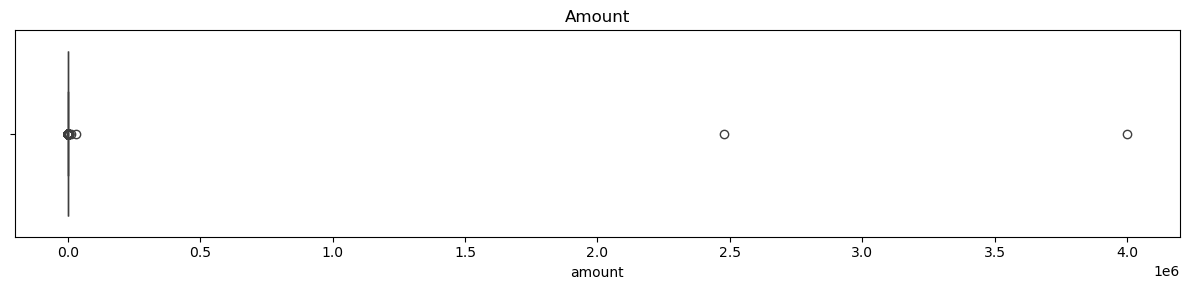

In [1686]:
# Verifying outliers using a boxplot

fig, ax = plt.subplots(figsize=(12, 3))

sns.boxplot(x=gifts['amount'])
ax.set_title('Amount')

plt.tight_layout()
plt.show()

In [1687]:
# Winsorizing the results
lower = gifts['amount'].quantile(0.01)
upper = gifts['amount'].quantile(0.99)

# printing the results
print('.01 quantile in amount:', lower)
print('.99 quantile in amount:', upper)

.01 quantile in amount: 2.48
.99 quantile in amount: 123.95


In [1688]:
# Replace lower and upper values by the value of bottom 1% and top 99% (winsorization)
gifts = gifts.copy()
gifts['amount'] = gifts['amount'].clip(lower=lower, upper=upper*3)

In [1689]:
print('The new maximum in amount is', gifts['amount'].max())

The new maximum in amount is 371.85


In [1690]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   donorID     216594 non-null  object        
 1   campaignID  216594 non-null  float64       
 2   amount      216594 non-null  float64       
 3   gift_date   216594 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 6.6+ MB


## 4) Selection campaign 6169

### General inspection

In [1691]:
# Displaying the sc6 table
sc6.head()

,donorID
0,D100001
1,D100002
2,D100004
3,D100008
4,D100009


### Missing values

In [1692]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc6.isna().sum())
print('---------------------------------')
print(f'The data shows {sc6.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


## 5) selection campaign 7244

### General inspection

In [1693]:
# Displaying the sc7 table
sc7.head()

,donorID
0,D100001
1,D100002
2,D100008
3,D100009
4,D100010


### Missing values

In [1694]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(sc7.isna().sum())
print('---------------------------------')
print(f'The data shows {sc7.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
donorID    0
dtype: int64
---------------------------------
The data shows 0 missing values


# II/ Dependent variables (train + validation set)

## 1) Train set

In [1695]:
# Setting up the campaign date
campaign_date_6169 = rd1
campaign_date_6169

Timestamp('2018-09-04 00:00:00')

We need to define our gap period. A gap period is crucial as it allows the model to train, to send the campaign and avoid data leakage.
A one month Gap period is geenrally considered a standard in the industry

In [1696]:
# Gap period: 1 week after campaign
gap_days = 7

In [1697]:
# End of the gap period 
gap_end = campaign_date_6169 + timedelta(days = gap_days)
gap_end

Timestamp('2018-09-11 00:00:00')

We define our response window. This is the period where we will check if someone donated after the campaign. We will use a window of 60 days in order to gather meaningful results quickly

In [1698]:
response_window = 60

In [1699]:
post_campaign_train = gifts[(gifts['gift_date'] > gap_end) & (gifts['gift_date'] <= gap_end + timedelta(response_window))]

# We verify that the window is respected
print(post_campaign_train.gift_date.min())
print(post_campaign_train.gift_date.max())

2018-09-12 00:00:00
2018-11-08 00:00:00


In [1700]:
post_campaign_train.head(3)

,donorID,campaignID,amount,gift_date
19,D100003,6922.0,4.0,2018-10-23
132,D100023,6169.0,15.0,2018-09-15
284,D100034,6170.0,45.0,2018-09-19


In [1701]:
responses_train = post_campaign_train.groupby('donorID')['amount'].sum().reset_index()

responses_train.head(3)

,donorID,amount
0,D100003,4.0
1,D100023,15.0
2,D100034,45.0


In [1702]:
sc6.head(2)

,donorID
0,D100001
1,D100002


In [1703]:
sc6.shape

(34888, 1)

In [1704]:
# Merging gifts and sc6 as gifts contains the donation history and we want to select those who were selected in the campaign

train_targets = sc6.merge(responses_train, on='donorID', how='left')
train_targets['amount'] = train_targets['amount'].fillna(0)
train_targets['target'] = (train_targets['amount'] >= donation).astype(int) # cast the values as binary, with >=30 = 1, else 0
train_targets = train_targets.drop(columns = 'amount')

train_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100004,0
3,D100008,0
4,D100009,0


In [1705]:
train_targets['target'].value_counts()
# 0 --> no donation above the threshold
# 1 --> donation above the threshold

target
0    34123
1      765
Name: count, dtype: int64

In [1706]:
train_targets.shape

(34888, 2)

## 2) Validation set

We follow the exact same steps and logic as we did before.

In [1707]:
campaign_date_7244 = rd2
campaign_date_7244

Timestamp('2019-06-18 00:00:00')

In [1708]:
# End of the gap period 
gap_end = campaign_date_7244 + timedelta(days = gap_days)
gap_end

Timestamp('2019-06-25 00:00:00')

In [1709]:
# We also use the same response window as in the train table 
post_campaign_validation = gifts[(gifts['gift_date'] > gap_end) & (gifts['gift_date'] <= gap_end + timedelta(response_window))]

print(post_campaign_validation.gift_date.min())
print(post_campaign_validation.gift_date.max())

2019-06-26 00:00:00
2019-08-24 00:00:00


In [1710]:
post_campaign_validation.head(3)

,donorID,campaignID,amount,gift_date
4042,D100548,0.0,50.0,2019-08-03
4780,D100607,0.0,4.0,2019-06-27
4781,D100607,0.0,4.0,2019-07-27


In [1711]:
responses_validation = post_campaign_validation.groupby('donorID')['amount'].sum().reset_index()

responses_validation.head(3)

,donorID,amount
0,D100548,50.0
1,D100607,8.0
2,D100724,40.0


In [1712]:
sc7.shape

(25645, 1)

In [1713]:
# Merging gifts and sc7 as gifts contains the donation history and we want to select those who were selected in the campaign

validation_targets = sc7.merge(responses_validation, on='donorID', how='left')
validation_targets['amount'] = validation_targets['amount'].fillna(0)
validation_targets['target'] = (validation_targets['amount'] >= donation).astype(int) # cast the values as binary, with >=30 = 1, else 0
validation_targets = validation_targets.drop(columns = 'amount')

validation_targets.head()

,donorID,target
0,D100001,0
1,D100002,0
2,D100008,0
3,D100009,0
4,D100010,0


In [1714]:
validation_targets['target'].value_counts()
# 0 --> no donation above the threshold
# 1 --> donation above the threshold

target
0    25464
1      181
Name: count, dtype: int64

In [1715]:
validation_targets.shape

(25645, 2)

# III/ Independent variable & basetable creation

## Training set

In [1716]:
train_features = sc6.copy()

In [1717]:
# Merge with donors table
train_features = train_features.merge(donors, on='donorID', how='left')

train_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29


### Demographics

#### Age

In [1718]:
# Calculate age at FEATURE CUTOFF date (Aug 5, 2018)
train_features["age"] = ( (campaign_date_6169.year - train_features["dateOfBirth"].dt.year))

# Fill missing ages with the median
train_features["age"] = train_features["age"].fillna(train_features["age"].median()).astype(int)

train_features.head(5)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29,66
3,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,81
4,D100009,1020,Brussels,Brussels,M,FR,1932-01-20,86


#### age_group

In [1719]:
# Computing the age group

train_features['age_group'] = train_features['age'].apply(lambda x : 'youth' if x<=25 
                                                          else('adult' if x>25 and x<40 
                                                               else('middle_aged' if x>=40 and x<65 
                                                                    else'senior')))

train_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age,age_group
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,51,middle_aged
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,66,senior
2,D100004,1020,Brussels,Brussels,F,FR,1952-03-29,66,senior


#### Dealing with categorical varaibles

We have many categorical variables (objects) that need to be one hot encoded as per models requirements

In [1720]:
# Selecting only the categorical variables 
obj_cols = train_features.select_dtypes(include='object').drop(columns='donorID').columns # exlude the donorID as it is not a feature
obj_cols

Index(['zipcode', 'province', 'region', 'gender', 'language', 'age_group'], dtype='object')

In [1721]:
# Visualization of data
for col in obj_cols:
    print('Number of unique values in', col, ':', train_features[col].nunique())

Number of unique values in zipcode : 963
Number of unique values in province : 12
Number of unique values in region : 3
Number of unique values in gender : 2
Number of unique values in language : 3
Number of unique values in age_group : 4


In [1722]:
# We first drop the zipcode variable a as it does not add any additional values given that we already have province and region
# One hot encoding is also impossible given the high number of unique values, this will pollute our models (eg. multicolinearity)

obj_cols = obj_cols.drop('zipcode')

train_features = train_features.drop(columns='zipcode')

'zipcode' in train_features

False

In [1723]:
# One-hot encoding categorical variables
train_features = pd.get_dummies(
    train_features,
    columns=obj_cols,
    drop_first=True
)

# Converting only the dummy columns (boolean → int)
bool_cols = train_features.select_dtypes(include="bool").columns
train_features[bool_cols] = train_features[bool_cols].astype(int)

train_features.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,province_Walloon Brabant,province_West Flanders,region_Flanders,region_Wallonia,gender_M,language_FR,language_NL,age_group_middle_aged,age_group_senior,age_group_youth
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,1,0
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


In [1724]:
train_features.shape

(34888, 22)

### Timing (RFM + LOR)

We first define our lookback days : our independent variables time window
- In theory we can take everything before the cutoff date that we defined earlier 
- However, we need to ensure that the train, validation and test tables have the same time window lenght
- Thus we need to define a lookback period that will be identical for all of them 

In [1725]:
# We define our lookback days
lookback_days = look_back   # look_back is a variable that was defined in References for convenience purposes (see table of contents)

# We define the start of our window given the lookback days
window_start_6169 = campaign_date_6169 - timedelta(lookback_days)

In [1726]:
# Use only gifts BEFORE the feature cutoff (gap respected)
gifts_before_6169 = gifts[
    (gifts["gift_date"] >= window_start_6169) &
    (gifts["gift_date"] < campaign_date_6169) # we do not inculde the campaign date because we want here to capture campaign free behavior
].copy()

gifts_before_6169.head(3)

,donorID,campaignID,amount,gift_date
0,D100001,0.0,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28


In [1727]:
# We group by donor and compute donation history metrics
rfm_6169 = gifts_before_6169.groupby("donorID").agg(
    first_gift=("gift_date", "min"),
    last_gift=("gift_date", "max"),
    frequency=("amount", "count"),
    total_amount=("amount", "sum"),
    avg_amount=("amount", "mean"),
    max_amount=("amount", "max"),
    min_amount=("amount", "min")
).reset_index()

rfm_6169.head()

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount
0,D100001,2004-03-23,2011-12-30,12,178.49,14.874167,30.00,6.69
1,D100002,2015-01-10,2015-01-10,1,20.00,20.000000,20.00,20.00
2,D100003,2017-07-27,2018-07-08,5,18.00,3.600000,5.00,3.00
3,D100004,2005-07-02,2011-06-03,26,716.22,27.546923,49.58,24.79
4,D100005,2006-10-07,2018-06-19,4,14.96,3.740000,5.00,2.48


In [1728]:
# We compute Recency
rfm_6169["recency_days"] = (campaign_date_6169 - rfm_6169["last_gift"]).dt.days

# Length Of Relationship (LOR)
rfm_6169["LOR"] = (rfm_6169["last_gift"] - rfm_6169["first_gift"]).dt.days

rfm_6169.head(3)

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days,LOR
0,D100001,2004-03-23,2011-12-30,12,178.49,14.874167,30.0,6.69,2440,2838
1,D100002,2015-01-10,2015-01-10,1,20.00,20.000000,20.0,20.00,1333,0
2,D100003,2017-07-27,2018-07-08,5,18.00,3.600000,5.0,3.00,58,346


In [1729]:
# Drop date columns (we already extracted useful info)
rfm_6169 = rfm_6169.drop(columns=["first_gift", "last_gift"])

### Donnation pattern

In [1730]:
# Donation variability (std)
std_amount_6169 = gifts_before_6169.groupby("donorID")["amount"].std().reset_index()
std_amount_6169.columns = ["donorID", "std_amount"]
rfm_6169 = rfm_6169.merge(std_amount_6169, on="donorID", how="left")
rfm_6169["std_amount"] = rfm_6169["std_amount"].fillna(0)

In [1731]:
print('Amount targetted =', donation)

Amount targetted = 30


In [1732]:
# Has ever donated >= amount targetted
donor_max_30_6169 = gifts_before_6169.groupby("donorID")["amount"].apply(lambda x: (x >= donation).any()).reset_index()
donor_max_30_6169.columns = ["donorID", "has_donated_30_plus"]
rfm_6169 = rfm_6169.merge(donor_max_30_6169, on="donorID", how="left")
rfm_6169["has_donated_30_plus"] = rfm_6169["has_donated_30_plus"].fillna(False).astype(int)

In [1733]:
# Percentage of donations >= amount targetted
pct_above_30_6169 = gifts_before_6169.groupby("donorID")["amount"].apply(lambda x: (x >= donation).sum() / len(x)).reset_index()
pct_above_30_6169.columns = ["donorID", "pct_donations_above_30"]
rfm_6169 = rfm_6169.merge(pct_above_30_6169, on="donorID", how="left")

In [1734]:
# Spontaneous donation rate (donations with campaignID = 0)
spontaneous_6169 = gifts_before_6169.groupby("donorID").apply(
    lambda x: (x["campaignID"] == 0).sum() / len(x) if len(x) > 0 else 0
).reset_index()
spontaneous_6169.columns = ["donorID", "spontaneous_donation_rate"]
rfm_6169 = rfm_6169.merge(spontaneous_6169, on="donorID", how="left")

In [1735]:
# Average days between donations
def avg_days_between(group):
    if len(group) < 2:
        return np.nan
    dates = group.sort_values()
    return dates.diff().dt.days.mean()

avg_interval_6169 = gifts_before_6169.groupby("donorID")["gift_date"].apply(avg_days_between).reset_index()
avg_interval_6169.columns = ["donorID", "avg_days_between_donations"]
rfm_6169 = rfm_6169.merge(avg_interval_6169, on="donorID", how="left")

In [1736]:
# Donation trend (slope of amount over time)
def donation_trend(group):
    if len(group) < 2:
        return 0
    group = group.sort_values("gift_date")
    x = np.arange(len(group))
    y = group["amount"].values
    if np.std(y) == 0:
        return 0
    slope = np.polyfit(x, y, 1)[0]
    return slope

trend_6169 = gifts_before_6169.groupby("donorID").apply(donation_trend).reset_index()
trend_6169.columns = ["donorID", "donation_trend"]
rfm_6169 = rfm_6169.merge(trend_6169, on="donorID", how="left")

In [1737]:
# Merge into your existing feature table
train_features = train_features.merge(rfm_6169, on="donorID", how="left")

In [1738]:
# Flag for donors with no donation history in the lookback window
train_features["has_no_donation_history"] = train_features["frequency"].isna().astype(int)

In [1739]:
train_features.head(3)

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,min_amount,recency_days,LOR,std_amount,has_donated_30_plus,pct_donations_above_30,spontaneous_donation_rate,avg_days_between_donations,donation_trend,has_no_donation_history
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,6.69,2440.0,2838.0,7.870151,1.0,0.083333,0.083333,258.00,-0.19472,0
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,20.00,1333.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.00000,0
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,24.79,2650.0,2162.0,5.142858,1.0,0.384615,0.038462,86.48,0.33185,0


In [1740]:
train_features.shape

(34888, 36)

### Campaign-specific

We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it. Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key

In [1741]:
print(gifts['campaignID'].dtype)
print(camp['campaignID'].dtype)


float64
int64


In [1742]:
# Changing dtype so we can put it into the model without errors and merge properly
camp['campaignID'] = camp['campaignID'].astype(float)
gifts['campaignID'] = gifts['campaignID'].astype(float)

In [1743]:
# Merge gifts with campaign metadata
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')
gifts_with_costs.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,2007-12-08,34080.0,0.21


In [1744]:
# Restrict to the same lookback window as RFM
history_campaigns_6169 = gifts_with_costs[
    (gifts_with_costs["gift_date"] >= window_start_6169) &
    (gifts_with_costs["gift_date"] < campaign_date_6169) # we still exclude like above (seek campaign free behavior here)
].copy()

history_campaigns_6169.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,2007-12-08,34080.0,0.21


In [1745]:
# How expensive are the campaigns they support? (we seek to get an idea of their relative importance)
 # What is the importance of the campaign they support
campaign_features_6169 = history_campaigns_6169.groupby("donorID").agg(
    CostUnit_mean   = ("CostUnit", "mean"),
    CostUnit_min    = ("CostUnit", "min"),
    CostUnit_max    = ("CostUnit", "max"),
    lettersSent_mean= ("lettersSent", "mean")
).reset_index()

campaign_features_6169.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean
0,D100001,0.335455,0.20,0.61,32877.454545
1,D100002,0.500000,0.50,0.50,37833.000000
2,D100003,0.196000,0.07,0.30,35984.792000


In [1746]:
# Cost range = variability in campaign cost
campaign_features_6169["CostUnit_range"] = (campaign_features_6169["CostUnit_max"] - campaign_features_6169["CostUnit_min"])

campaign_features_6169.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,0.335455,0.20,0.61,32877.454545,0.41
1,D100002,0.500000,0.50,0.50,37833.000000,0.00
2,D100003,0.196000,0.07,0.30,35984.792000,0.23


In [1747]:
# Merging everything in one basetable

basetable_train = train_features.merge(campaign_features_6169, on="donorID", how="left")

basetable_train.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,pct_donations_above_30,spontaneous_donation_rate,avg_days_between_donations,donation_trend,has_no_donation_history,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,0.083333,0.083333,258.00,-0.194720,0,0.335455,0.20,0.61,32877.454545,0.41
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,0.000000,0.000000,NaN,0.000000,0,0.500000,0.50,0.50,37833.000000,0.00
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,0.384615,0.038462,86.48,0.331850,0,0.305200,0.02,0.61,33428.240000,0.59
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,0.666667,0.000000,795.00,0.210000,0,0.440000,0.20,0.61,30994.000000,0.41
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,0.000000,0.000000,125.50,0.586526,0,0.433158,0.12,0.61,34788.105263,0.49


In [1748]:
# Other features

# Average donation per letter received
basetable_train["amount_per_letter"] = (basetable_train["total_amount"] / (basetable_train["lettersSent_mean"] + 1))

# Gifts per year relative to length of relationship in the window
basetable_train["gifts_per_year"] = (basetable_train["frequency"] / (basetable_train["LOR"] / 365 + 1))

# Ratio of most recent max value vs average donation
basetable_train["current_value_ratio"] = (basetable_train["max_amount"] / (basetable_train["avg_amount"] + 1))

# The +1 is added to the denominator to prevent division by zero when the original variable can be zero or missing
# Safety trick to avoid infinite or undefined values during feature engineering

In [1749]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     34888 non-null  object        
 1   dateOfBirth                 34872 non-null  datetime64[ns]
 2   age                         34888 non-null  int64         
 3   province_Antwerp            34888 non-null  int64         
 4   province_Brussels           34888 non-null  int64         
 5   province_East Flanders      34888 non-null  int64         
 6   province_Flemish Brabant    34888 non-null  int64         
 7   province_Hainaut            34888 non-null  int64         
 8   province_Liege              34888 non-null  int64         
 9   province_Limburg            34888 non-null  int64         
 10  province_Luxembourg         34888 non-null  int64         
 11  province_Namur              34888 non-null  int64     

In [1750]:
basetable_train.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,donation_trend,has_no_donation_history,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
0,D100001,1967-12-24,51,0,0,0,1,0,0,0,...,-0.194720,0,0.335455,0.20,0.61,32877.454545,0.41,0.005429,1.367468,1.889863
1,D100002,1952-01-14,66,1,0,0,0,0,0,0,...,0.000000,0,0.500000,0.50,0.50,37833.000000,0.00,0.000529,1.000000,0.952381
2,D100004,1952-03-29,66,0,1,0,0,0,0,0,...,0.331850,0,0.305200,0.02,0.61,33428.240000,0.59,0.021425,3.755441,1.736790
3,D100008,1937-08-30,81,0,0,0,1,0,0,0,...,0.210000,0,0.440000,0.20,0.61,30994.000000,0.41,0.004013,0.560102,1.177671
4,D100009,1932-01-20,86,0,1,0,0,0,0,0,...,0.586526,0,0.433158,0.12,0.61,34788.105263,0.49,0.009393,2.642912,1.373706


In [1751]:
basetable_train.shape

(34888, 44)

## 2) Validation set

In [1752]:
val_features = sc7.copy()

In [1753]:
# Merge with donors table
val_features = val_features.merge(donors, on='donorID', how='left')

val_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30


### a) demographic

#### age

In [1754]:
# Calculate age at feature cutoff date (Aug 5, 2018)
val_features["age"] = ( (campaign_date_7244.year - val_features["dateOfBirth"].dt.year))

# Fill missing ages with the median
val_features["age"] = val_features["age"].fillna(val_features["age"].median()).astype(int)

val_features.head(5)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,52
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,67
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,82
3,D100009,1020,Brussels,Brussels,M,FR,1932-01-20,87
4,D100010,1020,Brussels,Brussels,M,FR,1983-05-30,36


#### age_group

In [1755]:
# Computing the age group

val_features['age_group'] = val_features['age'].apply(lambda x : 'youth' if x<=25 
                                                          else('adult' if x>25 and x<40 
                                                               else('middle_aged' if x>=40 and x<65 
                                                                    else'senior')))

val_features.head(3)

,donorID,zipcode,province,region,gender,language,dateOfBirth,age,age_group
0,D100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,52,middle_aged
1,D100002,2260,Antwerp,Flanders,M,NL,1952-01-14,67,senior
2,D100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,82,senior


#### Dealing with categorical varaibles

We have many categorical variables (objects) that need to be one hot encoded as per models requirements

In [1756]:
# Selecting only the categorical variables 
obj_cols = val_features.select_dtypes(include='object').drop(columns='donorID').columns # exlude the donorID as it is not a feature
obj_cols

Index(['zipcode', 'province', 'region', 'gender', 'language', 'age_group'], dtype='object')

In [1757]:
for col in obj_cols:
    print('Number of unique values in', col, ':', val_features[col].nunique())

Number of unique values in zipcode : 939
Number of unique values in province : 12
Number of unique values in region : 3
Number of unique values in gender : 2
Number of unique values in language : 3
Number of unique values in age_group : 4


In [1758]:
# We first drop the zipcode varaiblea as it does not add any additional values given that we already have province and region
# One hot encoding is also impossible given the high number of unique values, this will pollute our models (eg. multicolinearity)

obj_cols = obj_cols.drop('zipcode')

val_features = val_features.drop(columns='zipcode')

'zipcode' in val_features

False

In [1759]:
# One-hot encode categorical variables
val_features = pd.get_dummies(
    val_features,
    columns=obj_cols,
    drop_first=True)

In [1760]:
# Convert only the dummy columns
bool_cols = val_features.select_dtypes(include="bool").columns
val_features[bool_cols] = val_features[bool_cols].astype(int)

val_features.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,province_Walloon Brabant,province_West Flanders,region_Flanders,region_Wallonia,gender_M,language_FR,language_NL,age_group_middle_aged,age_group_senior,age_group_youth
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,0,0,1,0,1,1,0,0,1,0
3,D100009,1932-01-20,87,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
4,D100010,1983-05-30,36,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [1761]:
val_features.shape

(25645, 22)

### Timing (RFM + LOR)

We first define our lookback days : our independent variables time window
- In theory we can take everything before the cutoff date that we defined earlier 
- However, we need to ensure that the train, validation and test tables have the same time window lenght
- Thus we need to define a lookback period that will be identical for all of them 

In [1762]:
# We define our lookback days
lookback_days = look_back  # same

# We define the start of our window given the lookback days
window_start_7244 = campaign_date_7244 - timedelta(lookback_days)

In [1763]:
# Use only gifts BEFORE the feature cutoff (gap respected)
gifts_before_7244 = gifts[
    (gifts["gift_date"] >= window_start_7244) &
    (gifts["gift_date"] < campaign_date_7244) # same
].copy()

gifts_before_7244.head(3)

,donorID,campaignID,amount,gift_date
0,D100001,0.0,12.39,2004-03-23
1,D100001,1577.0,12.39,2007-10-11
2,D100001,1634.0,6.69,2007-12-28


In [1764]:
# We group by donor and compute donation history metrics
rfm_7244 = gifts_before_7244.groupby("donorID").agg(
    first_gift=("gift_date", "min"),
    last_gift=("gift_date", "max"),
    frequency=("amount", "count"),
    total_amount=("amount", "sum"),
    avg_amount=("amount", "mean"),
    max_amount=("amount", "max"),
    min_amount=("amount", "min")
).reset_index()

rfm_7244.head()

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount
0,D100001,2004-03-23,2011-12-30,12,178.49,14.874167,30.00,6.69
1,D100002,2015-01-10,2015-01-10,1,20.00,20.000000,20.00,20.00
2,D100003,2017-07-27,2019-06-17,12,46.00,3.833333,5.00,3.00
3,D100004,2005-07-02,2011-06-03,26,716.22,27.546923,49.58,24.79
4,D100005,2006-10-07,2019-04-18,5,24.96,4.992000,10.00,2.48


In [1765]:
# We compute RECENCY and TENURE
rfm_7244["recency_days"] = (campaign_date_7244 - rfm_7244["last_gift"]).dt.days

rfm_7244.head(3)

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days
0,D100001,2004-03-23,2011-12-30,12,178.49,14.874167,30.0,6.69,2727
1,D100002,2015-01-10,2015-01-10,1,20.00,20.000000,20.0,20.00,1620
2,D100003,2017-07-27,2019-06-17,12,46.00,3.833333,5.0,3.00,1


In [1766]:
# Length Of Relationship (LOR)
rfm_7244["LOR"] = (rfm_7244["last_gift"] - rfm_7244["first_gift"]).dt.days

rfm_7244.head(3)

,donorID,first_gift,last_gift,frequency,total_amount,avg_amount,max_amount,min_amount,recency_days,LOR
0,D100001,2004-03-23,2011-12-30,12,178.49,14.874167,30.0,6.69,2727,2838
1,D100002,2015-01-10,2015-01-10,1,20.00,20.000000,20.0,20.00,1620,0
2,D100003,2017-07-27,2019-06-17,12,46.00,3.833333,5.0,3.00,1,690


In [1767]:
# Drop date columns (we already extracted useful info)
rfm_7244 = rfm_7244.drop(columns=["first_gift", "last_gift"])

### Donnation pattern

In [1768]:
# Donation variability (std)
std_amount_7244 = gifts_before_7244.groupby("donorID")["amount"].std().reset_index()
std_amount_7244.columns = ["donorID", "std_amount"]
rfm_7244 = rfm_7244.merge(std_amount_7244, on="donorID", how="left")
rfm_7244["std_amount"] = rfm_7244["std_amount"].fillna(0)

In [1769]:
# Has ever donated more than targetted amount
donor_max_30_7244 = gifts_before_7244.groupby("donorID")["amount"].apply(lambda x: (x >= donation).any()).reset_index()
donor_max_30_7244.columns = ["donorID", "has_donated_30_plus"]
rfm_7244 = rfm_7244.merge(donor_max_30_7244, on="donorID", how="left")
rfm_7244["has_donated_30_plus"] = rfm_7244["has_donated_30_plus"].fillna(False).astype(int)

In [1770]:
# Percentage of donations >= targetted amount
pct_above_30_7244 = gifts_before_7244.groupby("donorID")["amount"].apply(lambda x: (x >= donation).sum() / len(x)).reset_index()
pct_above_30_7244.columns = ["donorID", "pct_donations_above_30"]
rfm_7244 = rfm_7244.merge(pct_above_30_7244, on="donorID", how="left")

In [1771]:
# Spontaneous donation rate (donations with campaignID = 0)
spontaneous_7244 = gifts_before_7244.groupby("donorID").apply(
    lambda x: (x["campaignID"] == 0).sum() / len(x) if len(x) > 0 else 0
).reset_index()
spontaneous_7244.columns = ["donorID", "spontaneous_donation_rate"]
rfm_7244 = rfm_7244.merge(spontaneous_7244, on="donorID", how="left")

In [1772]:
# Average days between donations
def avg_days_between(group):
    if len(group) < 2:
        return np.nan
    dates = group.sort_values()
    return dates.diff().dt.days.mean()

avg_interval_7244 = gifts_before_7244.groupby("donorID")["gift_date"].apply(avg_days_between).reset_index()
avg_interval_7244.columns = ["donorID", "avg_days_between_donations"]
rfm_7244 = rfm_7244.merge(avg_interval_7244, on="donorID", how="left")

In [1773]:
# Donation trend (slope of amount over time)
def donation_trend(group):
    if len(group) < 2:
        return 0
    group = group.sort_values("gift_date")
    x = np.arange(len(group))
    y = group["amount"].values
    if np.std(y) == 0:
        return 0
    slope = np.polyfit(x, y, 1)[0]
    return slope

trend_7244 = gifts_before_7244.groupby("donorID").apply(donation_trend).reset_index()
trend_7244.columns = ["donorID", "donation_trend"]
rfm_7244 = rfm_7244.merge(trend_7244, on="donorID", how="left")

In [1774]:
# Merge into your existing feature table
val_features = val_features.merge(rfm_7244, on="donorID", how="left")

In [1775]:
# Flag for donors with no donation history in the lookback window
val_features["has_no_donation_history"] = val_features["frequency"].isna().astype(int)

In [1776]:
val_features.head(3)

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,min_amount,recency_days,LOR,std_amount,has_donated_30_plus,pct_donations_above_30,spontaneous_donation_rate,avg_days_between_donations,donation_trend,has_no_donation_history
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,6.69,2727.0,2838.0,7.870151,1.0,0.083333,0.083333,258.0,-0.19472,0
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,20.00,1620.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,0.00000,0
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,24.79,2790.0,1590.0,14.435284,1.0,0.666667,0.000000,795.0,0.21000,0


In [1777]:
val_features.shape

(25645, 36)

### Campaign-specific

We need this to get 'CostUnit' associated with each gift, therefore, we will temporarily merge gifts and campaign data to get it. Indeed, gift is the only table that can link our basetable with campaign, since it has the campaignID key

In [1778]:
print(gifts['campaignID'].dtype)
print(camp['campaignID'].dtype)

float64
float64


In [1779]:
camp['campaignID'] = camp['campaignID'].astype(float)
gifts['campaignID'] = gifts['campaignID'].astype(float)

In [1780]:
# Merge gifts with campaign metadata
gifts_with_costs = pd.merge(gifts, camp, on='campaignID', how='left')
gifts_with_costs.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,2007-12-08,34080.0,0.21


In [1781]:
# Restrict to the SAME lookback window as RFM
history_campaigns_7244 = gifts_with_costs[
    (gifts_with_costs["gift_date"] >= window_start_7244) &
    (gifts_with_costs["gift_date"] < campaign_date_7244)
].copy()

history_campaigns_7244.head(3)

,donorID,campaignID,amount,gift_date,date,lettersSent,CostUnit
0,D100001,0.0,12.39,2004-03-23,NaT,NaN,NaN
1,D100001,1577.0,12.39,2007-10-11,2007-10-09,34636.0,0.31
2,D100001,1634.0,6.69,2007-12-28,2007-12-08,34080.0,0.21


In [1782]:
# How expensive are the campaigns they support? (get an idea of their relative importance)
 # What is the importance of the campaign they support
campaign_features_7244 = history_campaigns_7244.groupby("donorID").agg(
    CostUnit_mean   = ("CostUnit", "mean"),
    CostUnit_min    = ("CostUnit", "min"),
    CostUnit_max    = ("CostUnit", "max"),
    lettersSent_mean= ("lettersSent", "mean")
).reset_index()

campaign_features_7244.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean
0,D100001,0.335455,0.20,0.61,32877.454545
1,D100002,0.500000,0.50,0.50,37833.000000
2,D100003,0.176667,0.04,0.30,31015.830000


In [1783]:
# Cost range = variability in campaign cost
campaign_features_7244["CostUnit_range"] = (
    campaign_features_7244["CostUnit_max"] - campaign_features_7244["CostUnit_min"]
)

campaign_features_7244.head(3)

,donorID,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,0.335455,0.20,0.61,32877.454545,0.41
1,D100002,0.500000,0.50,0.50,37833.000000,0.00
2,D100003,0.176667,0.04,0.30,31015.830000,0.26


In [1784]:
# Merging everything in one basetable

basetable_val = val_features.merge(campaign_features_7244, on="donorID", how="left")

basetable_val.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,pct_donations_above_30,spontaneous_donation_rate,avg_days_between_donations,donation_trend,has_no_donation_history,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,0.083333,0.083333,258.0,-0.194720,0,0.335455,0.20,0.61,32877.454545,0.41
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,0.000000,0.000000,NaN,0.000000,0,0.500000,0.50,0.50,37833.000000,0.00
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,0.666667,0.000000,795.0,0.210000,0,0.440000,0.20,0.61,30994.000000,0.41
3,D100009,1932-01-20,87,0,1,0,0,0,0,0,...,0.000000,0.000000,125.5,0.586526,0,0.433158,0.12,0.61,34788.105263,0.49
4,D100010,1983-05-30,36,0,1,0,0,0,0,0,...,1.000000,0.000000,NaN,0.000000,0,0.500000,0.50,0.50,37833.000000,0.00


In [1785]:
# Other features

# Average donation per letter received
basetable_val["amount_per_letter"] = (basetable_val["total_amount"] / (basetable_val["lettersSent_mean"] + 1))

# Gifts per year relative to length of relationship in the window
basetable_val["gifts_per_year"] = (basetable_val["frequency"] / (basetable_val["LOR"] / 365 + 1))

# Ratio of most recent max value vs average donation
basetable_val["current_value_ratio"] = (basetable_val["max_amount"] / (basetable_val["avg_amount"] + 1))

# same logic as before

In [1786]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     25645 non-null  object        
 1   dateOfBirth                 25644 non-null  datetime64[ns]
 2   age                         25645 non-null  int64         
 3   province_Antwerp            25645 non-null  int64         
 4   province_Brussels           25645 non-null  int64         
 5   province_East Flanders      25645 non-null  int64         
 6   province_Flemish Brabant    25645 non-null  int64         
 7   province_Hainaut            25645 non-null  int64         
 8   province_Liege              25645 non-null  int64         
 9   province_Limburg            25645 non-null  int64         
 10  province_Luxembourg         25645 non-null  int64         
 11  province_Namur              25645 non-null  int64     

In [1787]:
basetable_val.head()

,donorID,dateOfBirth,age,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,donation_trend,has_no_donation_history,CostUnit_mean,CostUnit_min,CostUnit_max,lettersSent_mean,CostUnit_range,amount_per_letter,gifts_per_year,current_value_ratio
0,D100001,1967-12-24,52,0,0,0,1,0,0,0,...,-0.194720,0,0.335455,0.20,0.61,32877.454545,0.41,0.005429,1.367468,1.889863
1,D100002,1952-01-14,67,1,0,0,0,0,0,0,...,0.000000,0,0.500000,0.50,0.50,37833.000000,0.00,0.000529,1.000000,0.952381
2,D100008,1937-08-30,82,0,0,0,1,0,0,0,...,0.210000,0,0.440000,0.20,0.61,30994.000000,0.41,0.004013,0.560102,1.177671
3,D100009,1932-01-20,87,0,1,0,0,0,0,0,...,0.586526,0,0.433158,0.12,0.61,34788.105263,0.49,0.009393,2.642912,1.373706
4,D100010,1983-05-30,36,0,1,0,0,0,0,0,...,0.000000,0,0.500000,0.50,0.50,37833.000000,0.00,0.001057,1.000000,0.975610


In [1788]:
basetable_val.shape

(25645, 44)

# IV/ Data cleaning

## 1) Basetable_train

### a) Cleaning columns

In [1789]:
basetable_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     34888 non-null  object        
 1   dateOfBirth                 34872 non-null  datetime64[ns]
 2   age                         34888 non-null  int64         
 3   province_Antwerp            34888 non-null  int64         
 4   province_Brussels           34888 non-null  int64         
 5   province_East Flanders      34888 non-null  int64         
 6   province_Flemish Brabant    34888 non-null  int64         
 7   province_Hainaut            34888 non-null  int64         
 8   province_Liege              34888 non-null  int64         
 9   province_Limburg            34888 non-null  int64         
 10  province_Luxembourg         34888 non-null  int64         
 11  province_Namur              34888 non-null  int64     

In [1790]:
# Dropping
basetable_train = basetable_train.drop(columns=['dateOfBirth'])
'dateOfBirth' in basetable_train

False

In [1791]:
# Setting donorID to index
basetable_train = basetable_train.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

### b) Missing values

In [1792]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_train.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_train.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
age                               0
province_Antwerp                  0
province_Brussels                 0
province_East Flanders            0
province_Flemish Brabant          0
province_Hainaut                  0
province_Liege                    0
province_Limburg                  0
province_Luxembourg               0
province_Namur                    0
province_Walloon Brabant          0
province_West Flanders            0
region_Flanders                   0
region_Wallonia                   0
gender_M                          0
language_FR                       0
language_NL                       0
age_group_middle_aged             0
age_group_senior                  0
age_group_youth                   0
frequency                        21
total_amount                     21
avg_amount                       21
max_amount                       21
min_amount                       21
recency_days                     21
LOR

In [1793]:
na_cols_train = basetable_train.columns

for col in na_cols_train:
    if basetable_train[col].isna().sum() == 0:
        na_cols_train = na_cols_train.drop(col)
    else:
        continue

na_cols_train

Index(['frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'recency_days', 'LOR', 'std_amount', 'has_donated_30_plus',
       'pct_donations_above_30', 'spontaneous_donation_rate',
       'avg_days_between_donations', 'donation_trend', 'CostUnit_mean',
       'CostUnit_min', 'CostUnit_max', 'lettersSent_mean', 'CostUnit_range',
       'amount_per_letter', 'gifts_per_year', 'current_value_ratio'],
      dtype='object')

In [1794]:
na_cols_train = na_cols_train.drop('recency_days') # recency should be inputed differently
na_cols_train = na_cols_train.drop('avg_days_between_donations')

In [1795]:
# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
for col in na_cols_train:
        basetable_train[col] = basetable_train[col].fillna(value=0)

In [1796]:
# We have to inpute recency with another value than 0 since 0 would mislead the model
# Indeed it would mean that as soon as the donnor received the mail, he would donate
basetable_train['recency_days'] = basetable_train['recency_days'].fillna(value=999)
basetable_train["avg_days_between_donations"] = basetable_train["avg_days_between_donations"].fillna(999)
# Using 999 is better than -1 because models would otherwise treat never-donors as if they donated very recently, which is conceptually wrong
# A large value like 999 makes never-donors behave like long-lapsed donors so it makes more sense than using -1

In [1797]:
print(f'There are {basetable_train.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### c) Outliers

In [1798]:
# Finding outliers (using only the numerical columns)
na_cols_train = na_cols_train.tolist()
na_cols_train.append('age') # we can see that the potential outliers are in the numerical tables which also presented NaNs
# Therefore, we only add age to these to look for outliers because age is the only other one that could present some outliers as well
na_cols_train

['frequency',
 'total_amount',
 'avg_amount',
 'max_amount',
 'min_amount',
 'LOR',
 'std_amount',
 'has_donated_30_plus',
 'pct_donations_above_30',
 'spontaneous_donation_rate',
 'donation_trend',
 'CostUnit_mean',
 'CostUnit_min',
 'CostUnit_max',
 'lettersSent_mean',
 'CostUnit_range',
 'amount_per_letter',
 'gifts_per_year',
 'current_value_ratio',
 'age']

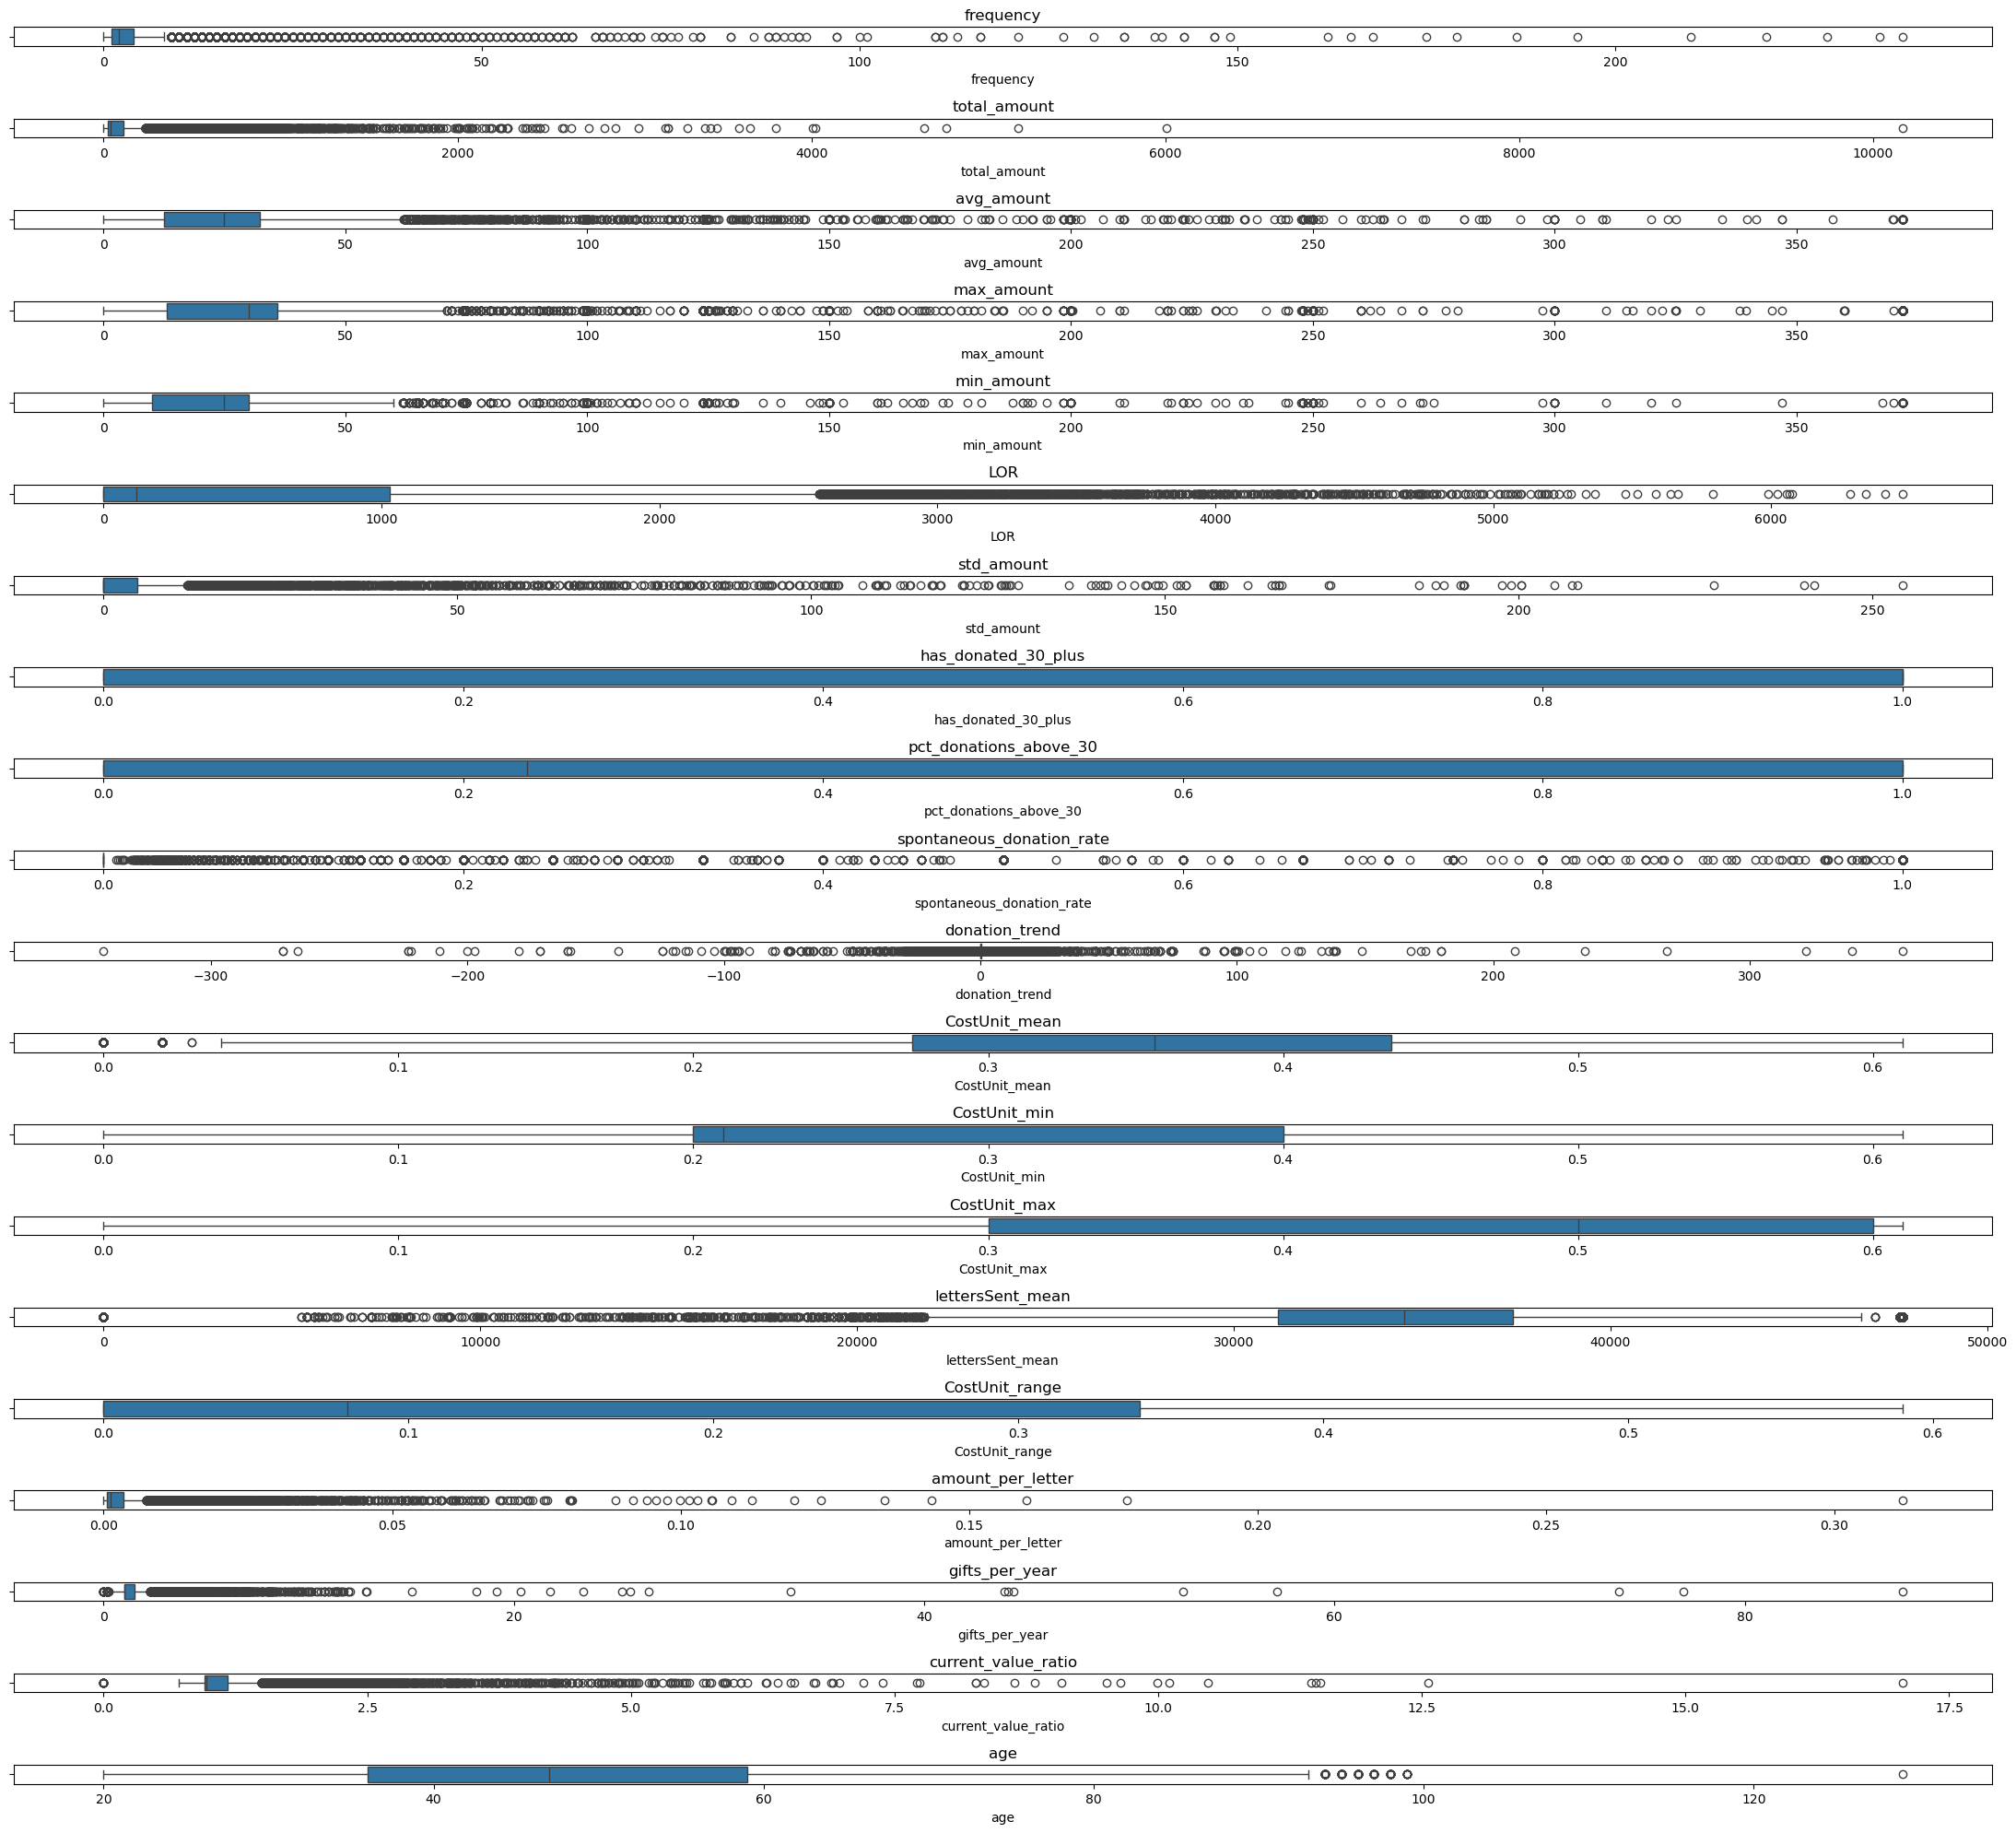

In [1799]:
# Verifying outliers

fig, ax = plt.subplots(nrows=len(na_cols_train), ncols=1, figsize=(22, 20))

for i, col in enumerate(na_cols_train):
    sns.boxplot(ax=ax[i], x=basetable_train[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [1800]:
# Removing the ages that are above 100
basetable_train = basetable_train[basetable_train['age'] < 100]
basetable_train['age'].max()

99

In [1801]:
# We decided to keep all the other variables with their 'outliers' because they represent a very large amount (find a justification)

## 2) basetable_val

### a) Cleaning columns

In [1802]:
basetable_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   donorID                     25645 non-null  object        
 1   dateOfBirth                 25644 non-null  datetime64[ns]
 2   age                         25645 non-null  int64         
 3   province_Antwerp            25645 non-null  int64         
 4   province_Brussels           25645 non-null  int64         
 5   province_East Flanders      25645 non-null  int64         
 6   province_Flemish Brabant    25645 non-null  int64         
 7   province_Hainaut            25645 non-null  int64         
 8   province_Liege              25645 non-null  int64         
 9   province_Limburg            25645 non-null  int64         
 10  province_Luxembourg         25645 non-null  int64         
 11  province_Namur              25645 non-null  int64     

In [1803]:
# Dropping
basetable_val = basetable_val.drop(columns=['dateOfBirth'])
'dateOfBirth' in basetable_val

False

In [1804]:
# Setting donorID to index
basetable_val = basetable_val.set_index('donorID') # Since we do not need it in the model but it still interesting to be reachable

### b) Missing values

In [1805]:
# Looking for missing values
print('Missing values per column:')
print('---------------------------------')
print(basetable_val.isna().sum())
print('---------------------------------')
print(f'The data shows {basetable_val.isna().sum().sum()} missing values')

Missing values per column:
---------------------------------
age                               0
province_Antwerp                  0
province_Brussels                 0
province_East Flanders            0
province_Flemish Brabant          0
province_Hainaut                  0
province_Liege                    0
province_Limburg                  0
province_Luxembourg               0
province_Namur                    0
province_Walloon Brabant          0
province_West Flanders            0
region_Flanders                   0
region_Wallonia                   0
gender_M                          0
language_FR                       0
language_NL                       0
age_group_middle_aged             0
age_group_senior                  0
age_group_youth                   0
frequency                         1
total_amount                      1
avg_amount                        1
max_amount                        1
min_amount                        1
recency_days                      1
LOR

In [1806]:
na_cols_val = basetable_val.columns

for col in na_cols_val:
    if basetable_val[col].isna().sum() == 0:
        na_cols_val = na_cols_val.drop(col)
    else:
        continue

na_cols_val

Index(['frequency', 'total_amount', 'avg_amount', 'max_amount', 'min_amount',
       'recency_days', 'LOR', 'std_amount', 'has_donated_30_plus',
       'pct_donations_above_30', 'spontaneous_donation_rate',
       'avg_days_between_donations', 'donation_trend', 'CostUnit_mean',
       'CostUnit_min', 'CostUnit_max', 'lettersSent_mean', 'CostUnit_range',
       'amount_per_letter', 'gifts_per_year', 'current_value_ratio'],
      dtype='object')

In [1807]:
na_cols_val = na_cols_val.drop('recency_days') # recency should be inputed differently
na_cols_val = na_cols_val.drop('avg_days_between_donations')

In [1808]:
# Inputing by 0 for the others (they likely represent the same clients as well because they are the same number and ad interconnected)
for col in na_cols_val:
        basetable_val[col] = basetable_val[col].fillna(value=0)

In [1809]:
# We have to inpute recency with another value than 0 since 0 would mislead the model
# Indeed it would mean that as soon as the donnor received the mail, he would donate
basetable_val['recency_days'] = basetable_val['recency_days'].fillna(value=999)
basetable_val["avg_days_between_donations"] = basetable_val["avg_days_between_donations"].fillna(999)
# Same logic as in the basetable_train

In [1810]:
print(f'There are {basetable_val.isna().sum().sum()} missing values in the basetable at this stage.')

There are 0 missing values in the basetable at this stage.


### c) Outliers

In [1811]:
# Finding outliers (using only the numerical columns)
na_cols_val = na_cols_val.tolist()
na_cols_val.append('age') # we can see that the potential outliers are in the numerical tables which also presented NaNs
# Therefore, we only add age to these to look for outliers because age is the only other one that could present some outliers as well
na_cols_val

['frequency',
 'total_amount',
 'avg_amount',
 'max_amount',
 'min_amount',
 'LOR',
 'std_amount',
 'has_donated_30_plus',
 'pct_donations_above_30',
 'spontaneous_donation_rate',
 'donation_trend',
 'CostUnit_mean',
 'CostUnit_min',
 'CostUnit_max',
 'lettersSent_mean',
 'CostUnit_range',
 'amount_per_letter',
 'gifts_per_year',
 'current_value_ratio',
 'age']

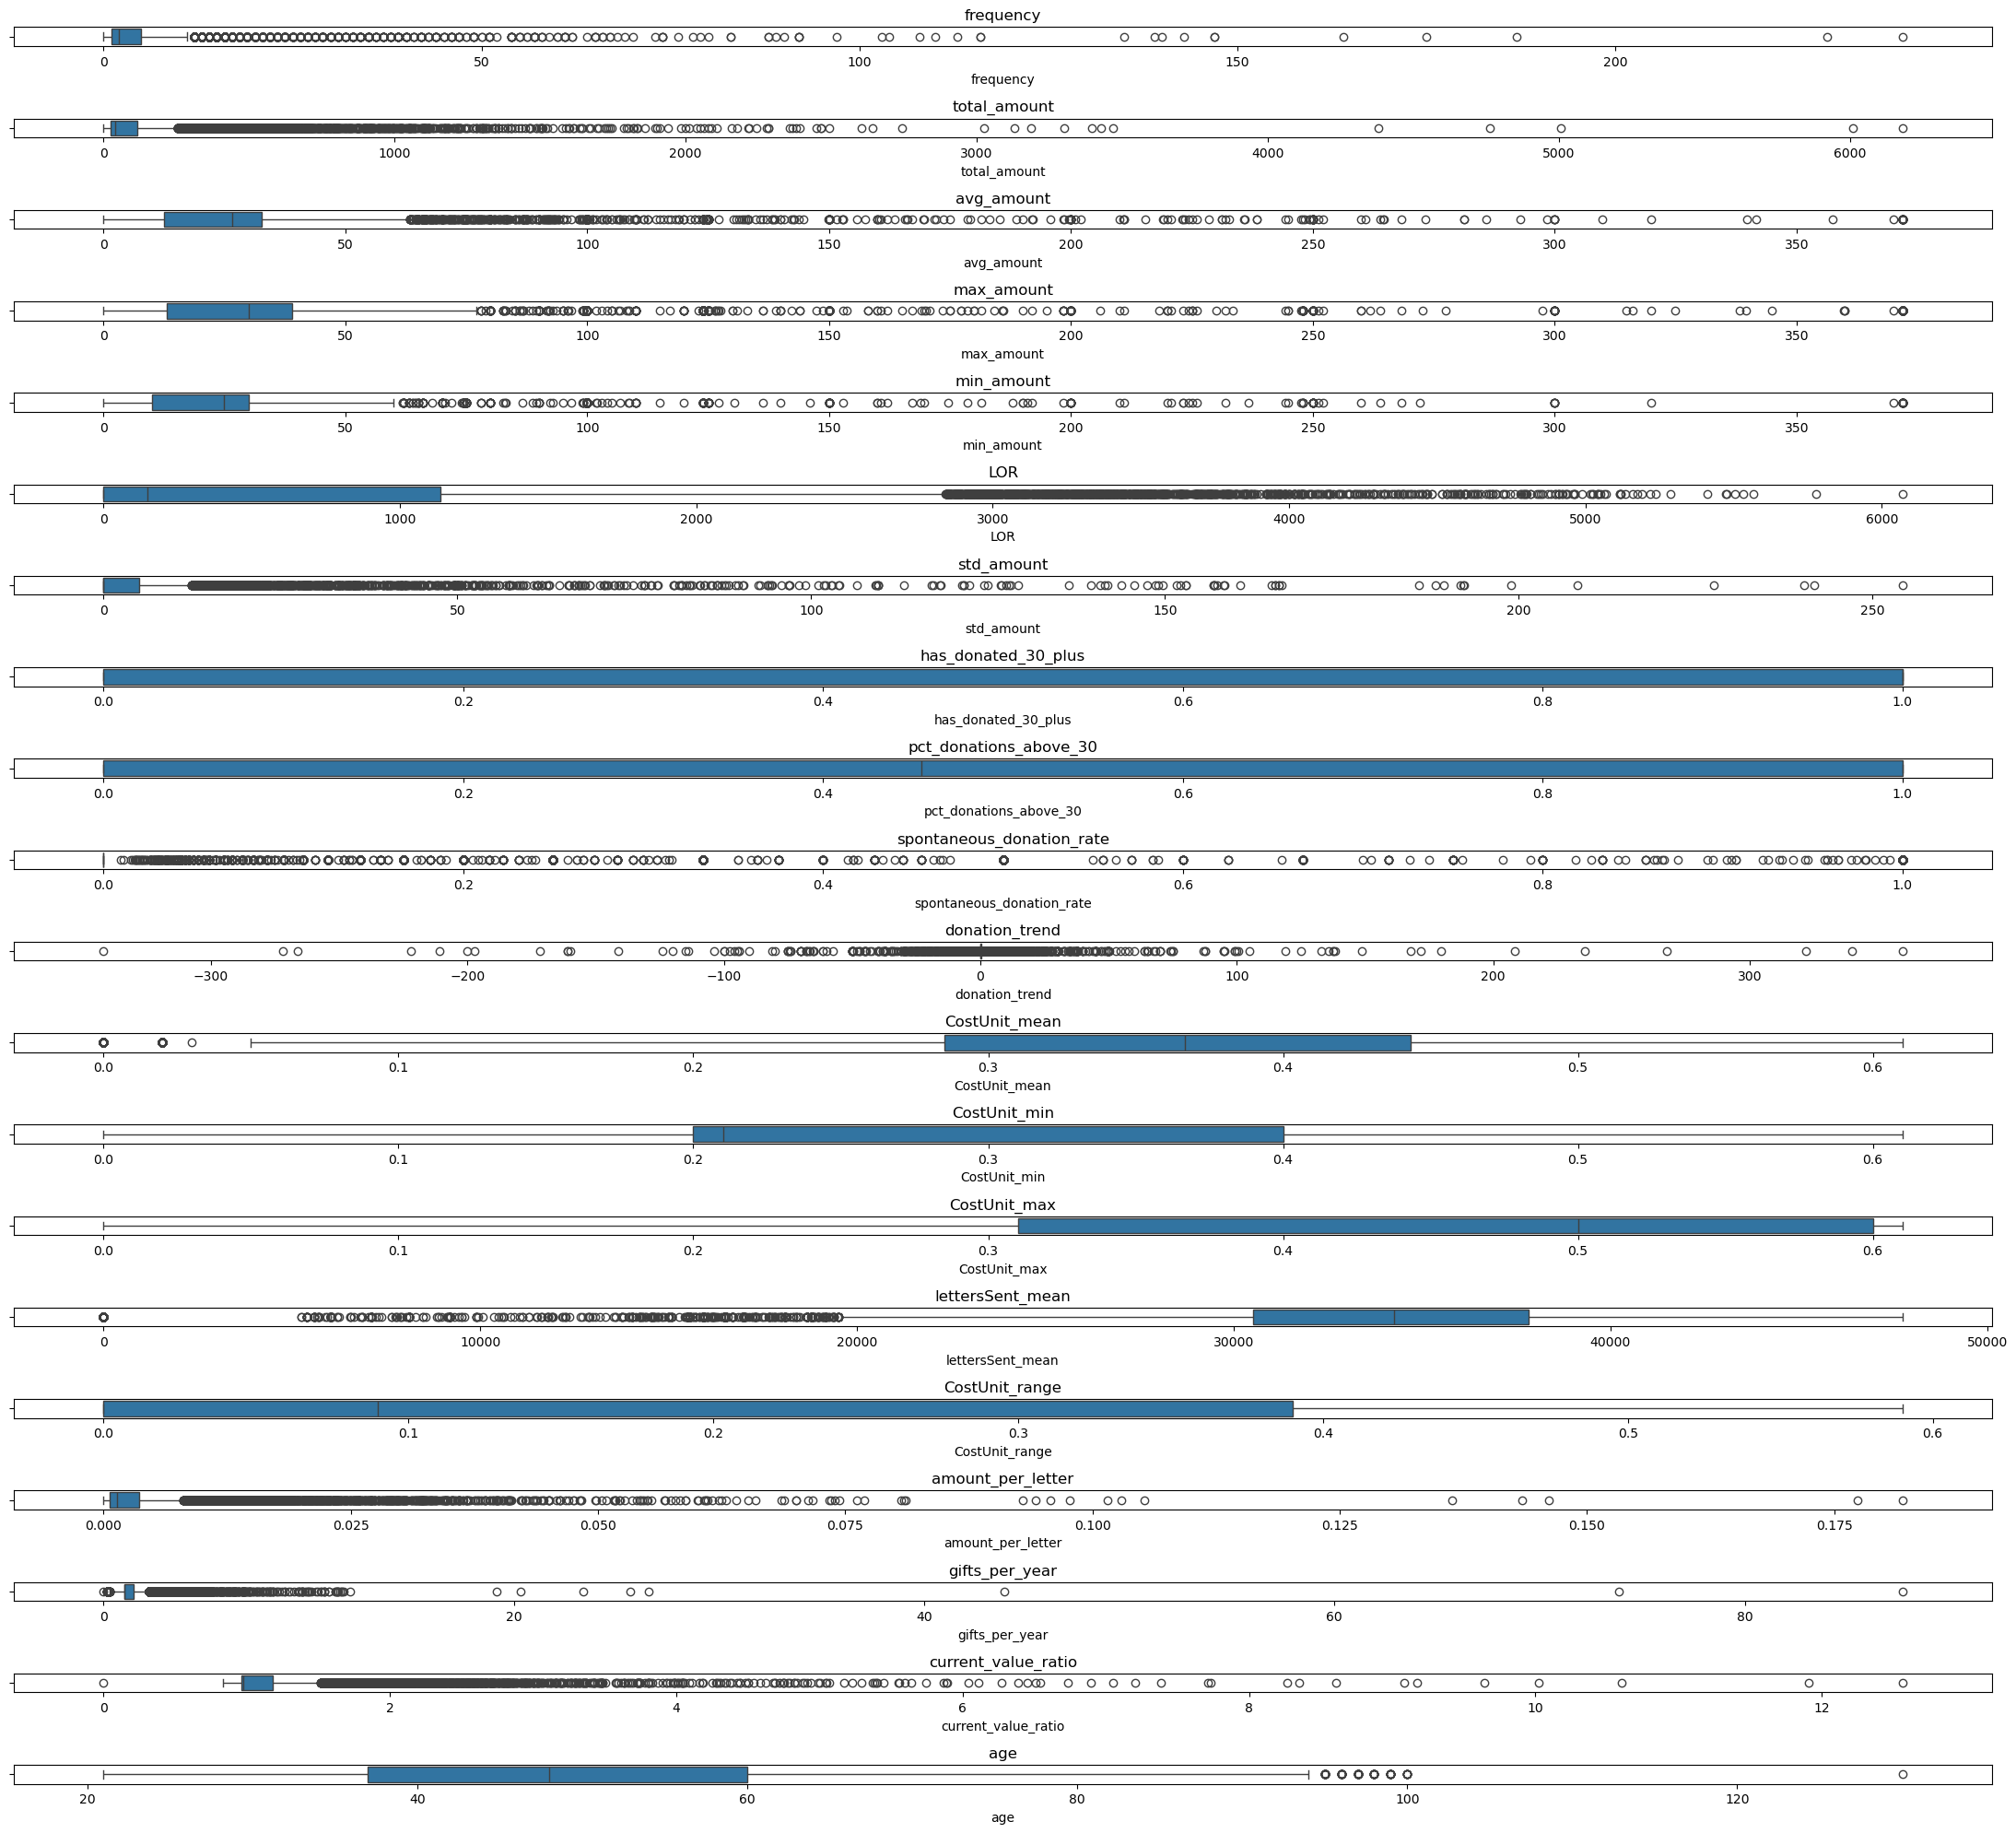

In [1812]:
# Verifying outliers

fig, ax = plt.subplots(nrows=len(na_cols_val), ncols=1, figsize=(22, 20))

for i, col in enumerate(na_cols_val):
    sns.boxplot(ax=ax[i], x=basetable_val[col])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [1813]:
# Removing the ages that are above 100
basetable_val = basetable_val[basetable_val['age'] < 100]
basetable_val['age'].max()

99

In [1814]:
# We decided to keep all the other variables with their 'outliers' because they represent a very large amount (find a justification)

# V/ Final data check

In [1815]:
train_targets.shape

(34888, 2)

In [1816]:
basetable_train.shape

(34887, 42)

In [1817]:
validation_targets.shape

(25645, 2)

In [1818]:
basetable_val.shape

(25636, 42)

In [1819]:
# We notice that we have one row less in the basetable_train
# This is due to the step when we filtered the basetable to remove the rows where
# the age was above 100 years old. We had only one (refer to the boxplot)
# Therefore, to adjust this situation, we have to merge the target variables into the basetable to be able to associate the right result with
# the right profile

In [1820]:
basetable_train = pd.merge(basetable_train, train_targets, left_index= True, right_on= 'donorID', how='left')
basetable_train.shape

(34887, 44)

In [1821]:
basetable_val = pd.merge(basetable_val, validation_targets, left_index= True, right_on= 'donorID', how='left')
basetable_val.shape

(25636, 44)

# Univariate analysis

In [1822]:
# Data preparation

# Prepare X and y
if 'donorID' in basetable_train.columns:
    X_train = basetable_train.drop(columns=['donorID', 'target']).select_dtypes(include=[np.number])
    X_val = basetable_val.drop(columns=['donorID', 'target']).select_dtypes(include=[np.number])
else:
    X_train = basetable_train.drop(columns=['target']).select_dtypes(include=[np.number])
    X_val = basetable_val.drop(columns=['target']).select_dtypes(include=[np.number])

y_train = basetable_train['target']
y_val = basetable_val['target']

# Fill NaN
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

print(f"Features: {X_train.shape[1]}")
print(f"Train: {len(X_train)} samples, {y_train.mean()*100:.2f}% positive")
print(f"Val: {len(X_val)} samples, {y_val.mean()*100:.2f}% positive")

Features: 42
Train: 34887 samples, 2.19% positive
Val: 25636 samples, 0.71% positive


In [1823]:
# Univariate analysis
univariate_results = []

for col in X_train.columns:
    try:
        val_auc = roc_auc_score(y_val, X_val[col])
        # Flip if AUC < 0.5 (feature has inverse relationship)
        if val_auc < 0.5:
            val_auc = 1 - val_auc
            direction = "negative"
        else:
            direction = "positive"
        
        univariate_results.append({
            'Feature': col,
            'Val_AUC': val_auc,
            'Direction': direction
        })
    except:
        univariate_results.append({
            'Feature': col,
            'Val_AUC': 0.5,
            'Direction': 'undefined'
        })

In [1824]:
# Creating a DataFrame and sort by AUC score
univariate_df = pd.DataFrame(univariate_results).sort_values('Val_AUC', ascending=False).reset_index(drop=True)
univariate_df['Rank'] = range(1, len(univariate_df) + 1)

print("                Feature Ranking by Validation AUC:")
print("_" * 50)
print(' ')
print(univariate_df.to_string(index=False))

                Feature Ranking by Validation AUC:
__________________________________________________
 
                   Feature  Val_AUC Direction  Rank
                max_amount 0.671553  positive     1
                avg_amount 0.669434  positive     2
                min_amount 0.650924  positive     3
              total_amount 0.624576  positive     4
         amount_per_letter 0.612239  positive     5
    pct_donations_above_30 0.594017  positive     6
                  gender_M 0.589002  negative     7
       current_value_ratio 0.588851  positive     8
       has_donated_30_plus 0.587796  positive     9
              recency_days 0.579542  negative    10
                       LOR 0.565238  positive    11
    province_West Flanders 0.550068  positive    12
                std_amount 0.547095  positive    13
            donation_trend 0.547013  positive    14
            gifts_per_year 0.545955  negative    15
                 frequency 0.540078  positive    16
          pr

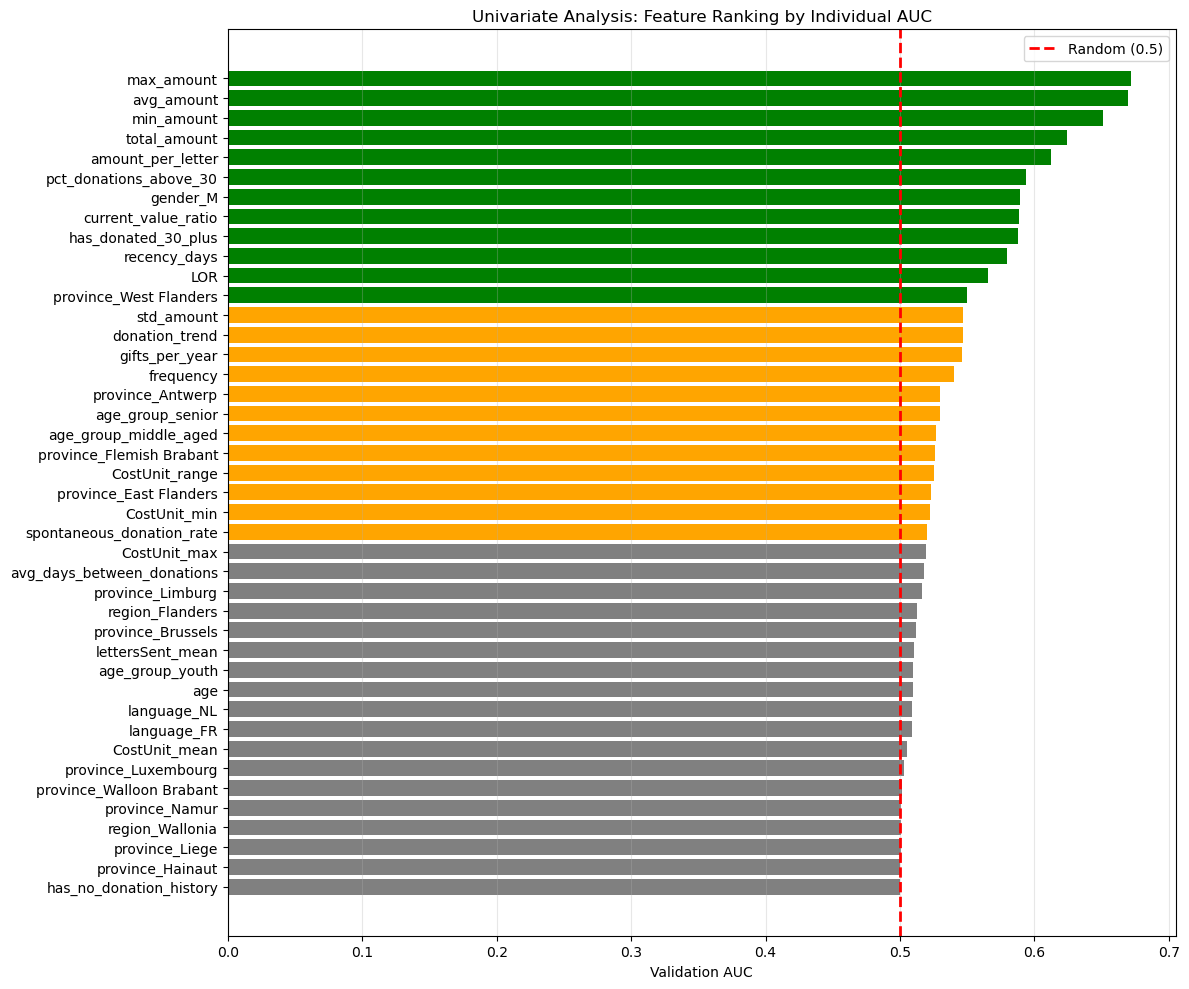

In [1825]:
# Plotting the results
fig, ax = plt.subplots(figsize=(12, 10))
colors = ['green' if auc > 0.55 else 'orange' if auc > 0.52 else 'gray' 
          for auc in univariate_df['Val_AUC']]
ax.barh(range(len(univariate_df)), univariate_df['Val_AUC'], color=colors)
ax.set_yticks(range(len(univariate_df)))
ax.set_yticklabels(univariate_df['Feature'])
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random (0.5)')
ax.set_xlabel('Validation AUC')
ax.set_title('Univariate Analysis: Feature Ranking by Individual AUC')
ax.invert_yaxis()
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [1826]:
# Getting an ordered feature list for stepwise
features_ordered = univariate_df['Feature'].tolist()

# Stepwise

In [1827]:
# Stepwise analysis using Univariate order
def stepwise_forward_selection_ordered(X_train, y_train, X_val, y_val, 
                                        features_ordered, max_features=20, 
                                        min_improvement=0.001):
    """
    Stepwise forward selection following the univariate AUC ranking order.
    Uses CV on training data for selection, validation for reporting only.
    """
    selected_features = []
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    best_cv_auc = 0.5
    
    print('Testing features in univariate AUC order')
    print("_"*60)
    
    for i, feature in enumerate(features_ordered[:max_features], 1):
        # Try adding this feature
        current_features = selected_features + [feature]
        
        # Evaluating with CV on training data
        model = LogisticRegression(max_iter=1000, random_state=42, 
                                   class_weight='balanced', C=0.1)
        cv_scores = cross_val_score(model, X_train[current_features], y_train, 
                                    cv=cv, scoring='roc_auc')
        cv_auc = cv_scores.mean()
        
        improvement = cv_auc - best_cv_auc
        
        # Only add if it improves the model
        if improvement >= min_improvement:
            selected_features.append(feature)
            best_cv_auc = cv_auc
            
            # Get validation AUC for reporting
            model.fit(X_train[selected_features], y_train)
            val_pred = model.predict_proba(X_val[selected_features])[:, 1]
            val_auc = roc_auc_score(y_val, val_pred)
            
            results.append({
                'Step': len(selected_features),
                'Feature_Added': feature,
                'CV_AUC': cv_auc,
                'Val_AUC': val_auc,
                'Improvement': improvement
            })
            
            print(f"✓ Step {len(selected_features):2d}: Added '{feature}'")
            print(f"   CV AUC: {cv_auc:.4f} | Val AUC: {val_auc:.4f} | Δ: +{improvement:.4f}")
        else:
            print(f"✗ Skipped '{feature}' (Δ = {improvement:+.4f} < {min_improvement})")
    
    return pd.DataFrame(results), selected_features

In [1828]:
# Run stepwise selection
stepwise_results, selected_features = stepwise_forward_selection_ordered(
    X_train, y_train, X_val, y_val,
    features_ordered=features_ordered,
    max_features=30,
    min_improvement=0.001
)

Testing features in univariate AUC order
____________________________________________________________
✓ Step  1: Added 'max_amount'
   CV AUC: 0.6175 | Val AUC: 0.6716 | Δ: +0.1175
✗ Skipped 'avg_amount' (Δ = -0.0128 < 0.001)
✗ Skipped 'min_amount' (Δ = -0.0130 < 0.001)
✗ Skipped 'total_amount' (Δ = -0.0169 < 0.001)
✓ Step  2: Added 'amount_per_letter'
   CV AUC: 0.6188 | Val AUC: 0.6709 | Δ: +0.0013
✗ Skipped 'pct_donations_above_30' (Δ = -0.0142 < 0.001)
✓ Step  3: Added 'gender_M'
   CV AUC: 0.7003 | Val AUC: 0.6680 | Δ: +0.0815
✗ Skipped 'current_value_ratio' (Δ = -0.0056 < 0.001)
✓ Step  4: Added 'has_donated_30_plus'
   CV AUC: 0.7014 | Val AUC: 0.6701 | Δ: +0.0011
✗ Skipped 'recency_days' (Δ = -0.0144 < 0.001)
✗ Skipped 'LOR' (Δ = -0.0123 < 0.001)
✗ Skipped 'province_West Flanders' (Δ = -0.0029 < 0.001)
✗ Skipped 'std_amount' (Δ = -0.0062 < 0.001)
✗ Skipped 'donation_trend' (Δ = -0.0033 < 0.001)
✗ Skipped 'gifts_per_year' (Δ = -0.0098 < 0.001)
✗ Skipped 'frequency' (Δ = -0.0061 

 Step       Feature_Added   CV_AUC  Val_AUC  Improvement
    1          max_amount 0.617533 0.671553     0.117533
    2   amount_per_letter 0.618816 0.670908     0.001283
    3            gender_M 0.700300 0.667986     0.081484
    4 has_donated_30_plus 0.701409 0.670055     0.001110
    5    age_group_senior 0.722162 0.660267     0.020753
 
Selected {len(selected_features)} features:
   1. max_amount
   2. amount_per_letter
   3. gender_M
   4. has_donated_30_plus
   5. age_group_senior


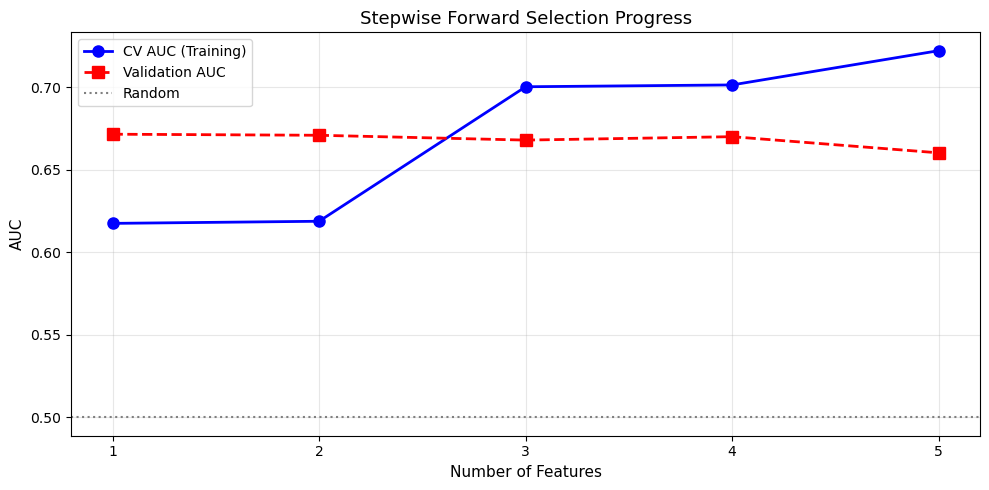

Final CV AUC: 0.7222
Final Val AUC: 0.6603


In [1829]:
# Results
if len(stepwise_results) > 0:
    print(stepwise_results.to_string(index=False))

    print(' ')
    
    print('Selected {len(selected_features)} features:')
    for i, feat in enumerate(selected_features, 1):
        print(f"   {i}. {feat}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(stepwise_results['Step'], stepwise_results['CV_AUC'], 'b-o', 
            linewidth=2, markersize=8, label='CV AUC (Training)')
    ax.plot(stepwise_results['Step'], stepwise_results['Val_AUC'], 'r--s', 
            linewidth=2, markersize=8, label='Validation AUC')
    ax.axhline(y=0.5, color='gray', linestyle=':', label='Random')
    ax.set_xlabel('Number of Features', fontsize=11)
    ax.set_ylabel('AUC', fontsize=11)
    ax.set_title('Stepwise Forward Selection Progress', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(stepwise_results['Step'])
    plt.tight_layout()
    plt.show()
    
    print(f'Final CV AUC: {stepwise_results['CV_AUC'].iloc[-1]:.4f}')
    print(f'Final Val AUC: {stepwise_results['Val_AUC'].iloc[-1]:.4f}')
else:
    print('No features met the improvement threshold.')

# Models implementation/ testing and results + business application

## 1) XGBoost

We chose to implement first a XGBoost model at this point because it appears to be a very relevant model for this kind of problems:

• It can handle class imbalance --> since only a few donors actually make a donnation, the data is very imbalanced. XGBoost has a built-in feature called scale_pos_weight that addresses specifically this kind of matter.

• It can also capture non-linear relationships --> can detect more complex patterns than other models.

• Is able to detect feature combination easily --> since it is decision tree based, it can see if some associations of features work best than separately.

• Not so sensitive to irrelevant features --> very important here because we do not have access to very advanced donnor data and therefore, finding highly impacteful features is not an easy task.

• Can handle various types of data (continuous and categorical)

• Has built-in features that can prevent overfitting such as its hyperparameters (max_depth/ min_child_weight or gamma)

## a) Model

In [ ]:
# For convenience purposes, we decided to put all the code within one cell that can be rerun easily when we want to adjust

Training Features shape: (34887, 42)
Validation Features shape: (25636, 42)
Class Imbalance Ratio: 1:44.60
Train positive rate: 2.19%
Val positive rate: 0.71%

Starting Hyperparameter Tuning with Early Stopping...
(This may take a few minutes)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best CV AUC Score: 0.9312
Best Parameters:
  colsample_bylevel: 0.7475884550556351
  colsample_bytree: 0.5171942605576092
  gamma: 0.9093204020787821
  learning_rate: 0.04881699724000254
  max_depth: 5
  min_child_weight: 6
  n_estimators: 489
  reg_alpha: 0.41588332573637765
  reg_lambda: 1.635400655639983
  scale_pos_weight: 22.301960784313724
  subsample: 0.9878338511058234

FINAL VALIDATION AUC: 0.7620

Trees used: 219 (early stopping)


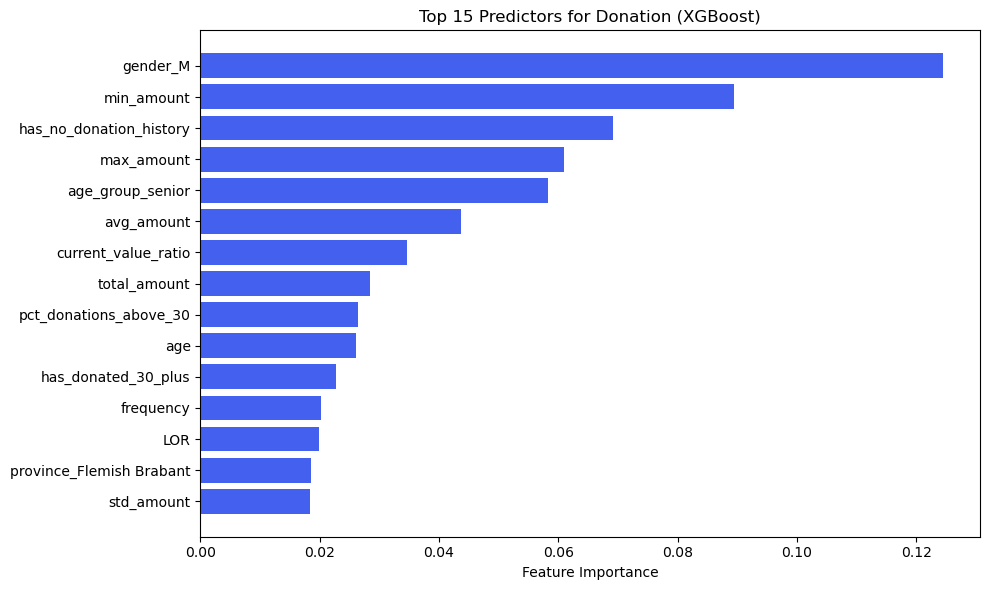


Top 15 Features:
                 Feature  Importance
                gender_M    0.124481
              min_amount    0.089439
 has_no_donation_history    0.069232
              max_amount    0.060921
        age_group_senior    0.058313
              avg_amount    0.043721
     current_value_ratio    0.034574
            total_amount    0.028442
  pct_donations_above_30    0.026504
                     age    0.026064
     has_donated_30_plus    0.022805
               frequency    0.020160
                     LOR    0.019854
province_Flemish Brabant    0.018504
              std_amount    0.018308


In [ ]:
#   XGBOOST MODEL

# - No StandardScaler --> unnecessary for tree-based models
# - Early stopping to prevent overfitting
# - Expanded hyperparameter search

# ------------------------------------------------------------------------------
# Data Preparation
# ------------------------------------------------------------------------------
if 'donorID' in basetable_train.columns:
    basetable_train = basetable_train.set_index('donorID')
if 'donorID' in basetable_val.columns:
    basetable_val = basetable_val.set_index('donorID')

X_train = basetable_train.drop(columns=['target']).select_dtypes(include=[np.number])
y_train = basetable_train['target']
X_val = basetable_val.drop(columns=['target']).select_dtypes(include=[np.number])
y_val = basetable_val['target']

# Fill NaN
X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

# Class imbalance ratio
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight_val = n_neg / n_pos

print(f"Training Features shape: {X_train.shape}")
print(f"Validation Features shape: {X_val.shape}")
print(f"Class Imbalance Ratio: 1:{scale_pos_weight_val:.2f}")
print(f"Train positive rate: {y_train.mean()*100:.2f}%")
print(f"Val positive rate: {y_val.mean()*100:.2f}%")

# ------------------------------------------------------------------------------
# XGBoost with Early Stopping (No Scaler)
# ------------------------------------------------------------------------------
# Note: No Pipeline needed since we removed StandardScaler

# Expanded hyperparameter search
param_distributions = {
    # Tree structure
    'max_depth': randint(2, 7),                    # Prevent overfitting
    'min_child_weight': randint(5, 50),            # Higher = more conservative
    
    # Learning
    'learning_rate': uniform(0.01, 0.15),          
    'n_estimators': randint(100, 500),             # Early stopping will find optimal
    
    # Regularization
    'gamma': uniform(0, 1.0),                      # Min loss reduction for split
    'reg_alpha': uniform(0, 2.0),                  # L1 regularization
    'reg_lambda': uniform(0.5, 2.0),               # L2 regularization
    
    # Subsampling (reduces overfitting)
    'subsample': uniform(0.6, 0.4),                
    'colsample_bytree': uniform(0.5, 0.5),         
    'colsample_bylevel': uniform(0.5, 0.5),        
    
    # Class imbalance - multiple options derived from class ratios
    'scale_pos_weight': [
        1,                                          # No adjustment
        scale_pos_weight_val,                       # Full adjustment
        np.sqrt(scale_pos_weight_val),              # Moderate adjustment
        np.log1p(scale_pos_weight_val),             # Conservative adjustment
        scale_pos_weight_val / 2                    # Half adjustment
    ]
}

# Base model with early stopping enabled
base_model = XGBClassifier(
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=50,      # Stop if no improvement for 50 rounds
    verbosity=0
)

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,                     # More iterations for better search
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit with eval_set for early stopping
search.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],     # Early stopping uses validation set
    verbose=False
)

best_model = search.best_estimator_
print(f"\nBest CV AUC Score: {search.best_score_:.4f}")
print(f"Best Parameters:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")

# ------------------------------------------------------------------------------
# Final Evaluation
# ------------------------------------------------------------------------------
y_pred_proba = best_model.predict_proba(X_val)[:, 1]
final_auc = roc_auc_score(y_val, y_pred_proba)

print("\n" + "="*50)
print(f"FINAL VALIDATION AUC: {final_auc:.4f}")
print("="*50)

# Actual number of trees used (with early stopping)
print(f"\nTrees used: {best_model.best_iteration + 1} (early stopping)")

# ------------------------------------------------------------------------------
# Feature Importance
# ------------------------------------------------------------------------------

feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Top 15 features
top_15 = feat_imp.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_15['Feature'], top_15['Importance'], color='#4361EE')
plt.xlabel('Feature Importance')
plt.title('Top 15 Predictors for Donation (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 15 Features:")
print(top_15.to_string(index=False))

--> Here we can see that the features used by the XGBoost differ from the ones chosen during the stepwise analysis. This is because the stepwise analysis is using Logistic Regression to identify 5 key features that provide the most linear predictive power. 

--> However, XGBoost, being a non-linear ensemble method, it leverages additional features to capture complex interactions and non-linear patterns, resulting in a higher AUC.

--> The top features from XGBoost's importance plot largely overlap with the stepwise selection, confirming their relevance.

--> Also, we removed StandardScaler from the XGBoost pipeline because tree-based models make decisions based on feature value thresholds (splits), not on feature magnitudes. 

--> Scaling is therefore unnecessary and can actually distort the natural distribution of sparse or one-hot encoded features.

### b) ROC curve

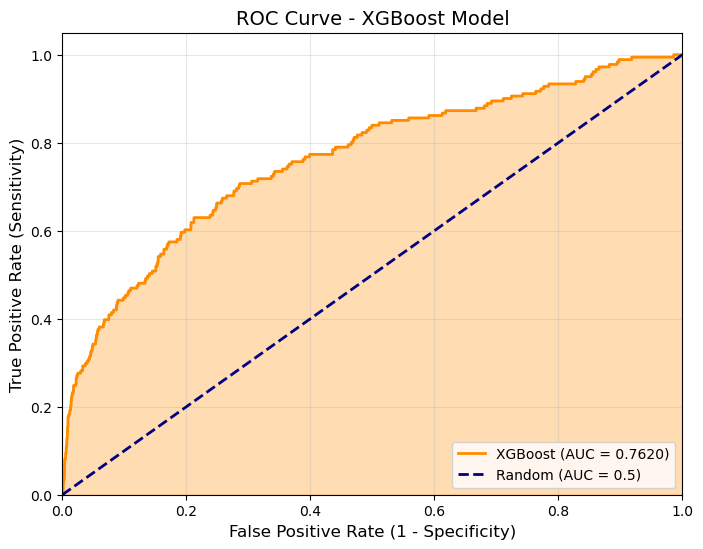

In [1832]:
# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_val, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGBoost (AUC = {final_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
ax.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title('ROC Curve - XGBoost Model', fontsize=14)
ax.legend(loc="lower right", fontsize=10)
ax.grid(True, alpha=0.3)

In [1833]:
# Optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds_roc[optimal_idx]
ax.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100,
           label=f'Optimal threshold = {optimal_threshold:.3f}', zorder=5)
ax.legend(loc="lower right", fontsize=10)

plt.tight_layout()
plt.show()

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"At optimal: TPR = {tpr[optimal_idx]:.4f}, FPR = {fpr[optimal_idx]:.4f}")

<Figure size 640x480 with 0 Axes>

Optimal threshold: 0.0964
At optimal: TPR = 0.7072, FPR = 0.2858


### c) Lift + cummulative lift curves

In [1834]:
# Lift curve
def calculate_lift_curve(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    df['decile'] = pd.qcut(df.index, n_bins, labels=False, duplicates='drop') + 1
    
    overall_rate = df['y_true'].mean()
    
    lift_data = df.groupby('decile').agg({
        'y_true': ['sum', 'count', 'mean']
    }).reset_index()
    lift_data.columns = ['Decile', 'Positives', 'Total', 'Response_Rate']
    
    lift_data['Lift'] = lift_data['Response_Rate'] / overall_rate
    lift_data['Cumulative_Positives'] = lift_data['Positives'].cumsum()
    lift_data['Cumulative_Total'] = lift_data['Total'].cumsum()
    lift_data['Cumulative_Response_Rate'] = lift_data['Cumulative_Positives'] / lift_data['Cumulative_Total']
    lift_data['Cumulative_Lift'] = lift_data['Cumulative_Response_Rate'] / overall_rate
    lift_data['Pct_Population'] = lift_data['Cumulative_Total'] / len(df) * 100
    
    return lift_data, overall_rate


Lift Table (by Decile):
 Decile  Total  Positives  Response_Rate     Lift  Cumulative_Lift
      1   2564         80       0.031201 4.419200         4.419200
      2   2564         28       0.010920 1.546720         2.982960
      3   2563         20       0.007803 1.105231         2.357213
      4   2564         11       0.004290 0.607640         1.919777
      5   2563         12       0.004682 0.663139         1.668508
      6   2564          5       0.001950 0.276200         1.436427
      7   2563          6       0.002341 0.331569         1.278625
      8   2564          7       0.002730 0.386680         1.167116
      9   2563         10       0.003902 0.552616         1.098853
     10   2564          2       0.000780 0.110480         1.000000


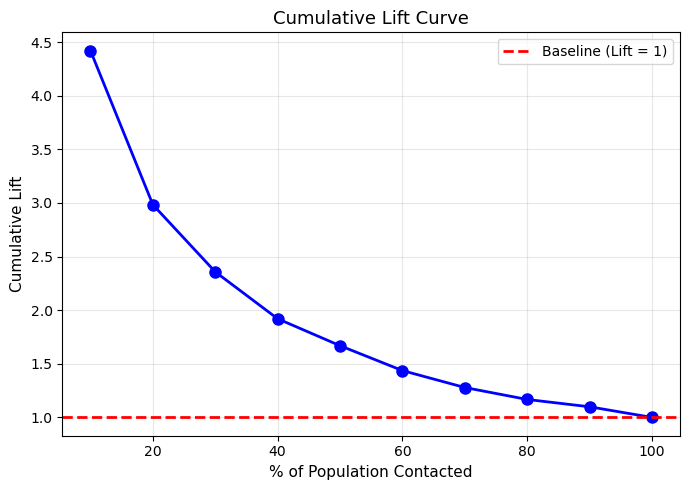

Top Decile Lift: 4.42x
Top 20% Cumulative Lift: 2.98x
Overall Response Rate: 0.71%
Top Decile Response Rate: 3.12%


In [1835]:
# Cumulative Lift Curve

lift_data, overall_rate = calculate_lift_curve(y_val.values, y_pred_proba, n_bins=10)

print("\nLift Table (by Decile):")
print(lift_data[['Decile', 'Total', 'Positives', 'Response_Rate', 'Lift', 'Cumulative_Lift']].to_string(index=False))

# Plotting the lift curve
plt.figure(figsize=(7, 5))

plt.plot(lift_data['Pct_Population'], lift_data['Cumulative_Lift'], 'b-o', linewidth=2, markersize=8)
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline (Lift = 1)')

plt.xlabel('% of Population Contacted', fontsize=11)
plt.ylabel('Cumulative Lift', fontsize=11)
plt.title('Cumulative Lift Curve', fontsize=13)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Top Decile Lift: {lift_data['Lift'].iloc[0]:.2f}x")
print(f"Top 20% Cumulative Lift: {lift_data['Cumulative_Lift'].iloc[1]:.2f}x")
print(f"Overall Response Rate: {overall_rate*100:.2f}%")
print(f"Top Decile Response Rate: {lift_data['Response_Rate'].iloc[0]*100:.2f}%")


### d) Cumulative gaings

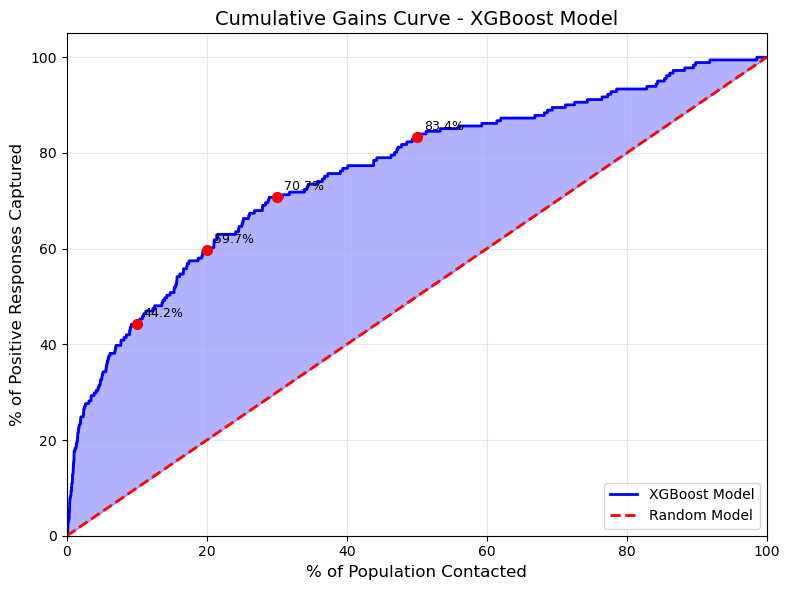

Cumulative Gains Summary:
________________________________________
Top 10% of population captures  44.2% of positives
Top 20% of population captures  59.7% of positives
Top 30% of population captures  70.7% of positives
Top 40% of population captures  76.8% of positives
Top 50% of population captures  83.4% of positives


In [1836]:
# Cumulative gains curve
def calculate_cumulative_gains(y_true, y_prob):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    df['cum_positives'] = df['y_true'].cumsum()
    df['pct_population'] = (df.index + 1) / total_samples * 100
    df['pct_positives_captured'] = df['cum_positives'] / total_positives * 100
    
    gains_data = pd.DataFrame({
        'pct_population': [0] + df['pct_population'].tolist(),
        'pct_positives_captured': [0] + df['pct_positives_captured'].tolist()
    })
    
    return gains_data

gains_data = calculate_cumulative_gains(y_val.values, y_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(gains_data['pct_population'], gains_data['pct_positives_captured'],
        'b-', linewidth=2, label='XGBoost Model')

ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Random Model')

total_pos_rate = y_val.mean()
perfect_x = [0, total_pos_rate * 100, 100]
perfect_y = [0, 100, 100]

ax.fill_between(gains_data['pct_population'],
                gains_data['pct_positives_captured'],
                gains_data['pct_population'],
                alpha=0.3, color='blue')

ax.set_xlabel('% of Population Contacted', fontsize=12)
ax.set_ylabel('% of Positive Responses Captured', fontsize=12)
ax.set_title('Cumulative Gains Curve - XGBoost Model', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 100])
ax.set_ylim([0, 105])

for pct in [10, 20, 30, 50]:
    idx = int(len(gains_data) * pct / 100)
    if idx < len(gains_data):
        captured = gains_data['pct_positives_captured'].iloc[idx]
        ax.scatter(pct, captured, color='red', s=50, zorder=5)
        ax.annotate(f'{captured:.1f}%', (pct, captured),
                   textcoords="offset points", xytext=(5, 5), fontsize=9)

plt.tight_layout()
plt.show()

print("Cumulative Gains Summary:")
print("_" * 40)
for pct in [10, 20, 30, 40, 50]:
    idx = int(len(gains_data) * pct / 100)
    if idx < len(gains_data):
        captured = gains_data['pct_positives_captured'].iloc[idx]
        print(f"Top {pct:2d}% of population captures {captured:5.1f}% of positives")

### e) Confusion matrix

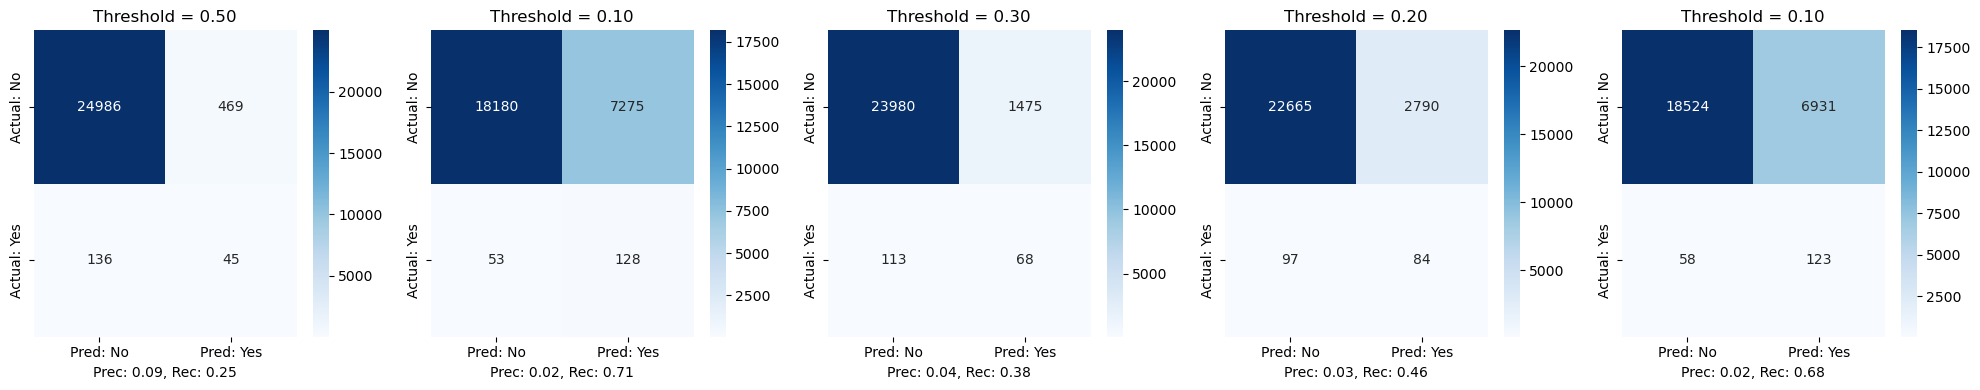

In [1837]:
# Confusion matrix

# Use optimal threshold from ROC curve
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Also show confusion matrix at different thresholds
thresholds_to_show = [0.5, optimal_threshold, 0.3, 0.2, 0.1]

fig, axes = plt.subplots(1, len(thresholds_to_show), figsize=(4*len(thresholds_to_show), 4))

for i, thresh in enumerate(thresholds_to_show):
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm = confusion_matrix(y_val, y_pred_thresh)
    
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Pred: No', 'Pred: Yes'],
                yticklabels=['Actual: No', 'Actual: Yes'])
    ax.set_title(f'Threshold = {thresh:.2f}')
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    ax.set_xlabel(f'Prec: {precision:.2f}, Rec: {recall:.2f}')

plt.tight_layout()
plt.show()

In [1838]:
# Detailed classification report at optimal threshold
print(f"Classification Report (Threshold = {optimal_threshold:.3f}):")
print("_" * 50)
print(' ')
print(classification_report(y_val, y_pred_optimal, target_names=['No Donation', 'Donation']))

# Confusion matrix details
cm = confusion_matrix(y_val, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix Details:")
print(f"  True Negatives (TN):  {tn:,}")
print(f"  False Positives (FP): {fp:,}")
print(f"  False Negatives (FN): {fn:,}")
print(f"  True Positives (TP):  {tp:,}")
print(f"\n  Accuracy:    {(tp+tn)/(tp+tn+fp+fn):.4f}")
print(f"  Precision:   {tp/(tp+fp) if (tp+fp) > 0 else 0:.4f}")
print(f"  Recall:      {tp/(tp+fn) if (tp+fn) > 0 else 0:.4f}")
print(f"  Specificity: {tn/(tn+fp) if (tn+fp) > 0 else 0:.4f}")
print(f"  F1-Score:    {2*tp/(2*tp+fp+fn) if (2*tp+fp+fn) > 0 else 0:.4f}")


Classification Report (Threshold = 0.096):
__________________________________________________
 
              precision    recall  f1-score   support

 No Donation       1.00      0.71      0.83     25455
    Donation       0.02      0.71      0.03       181

    accuracy                           0.71     25636
   macro avg       0.51      0.71      0.43     25636
weighted avg       0.99      0.71      0.83     25636


Confusion Matrix Details:
  True Negatives (TN):  18,180
  False Positives (FP): 7,275
  False Negatives (FN): 53
  True Positives (TP):  128

  Accuracy:    0.7142
  Precision:   0.0173
  Recall:      0.7072
  Specificity: 0.7142
  F1-Score:    0.0338


## 2) Logistic regression

LOGISTIC REGRESSION MODEL (Stepwise Features)
Features used: ['max_amount', 'amount_per_letter', 'gender_M', 'has_donated_30_plus', 'age_group_senior']
Training set: 34887 samples, 2.19% positive
Validation set: 25636 samples, 0.71% positive

LOGISTIC REGRESSION - VALIDATION AUC: 0.6524


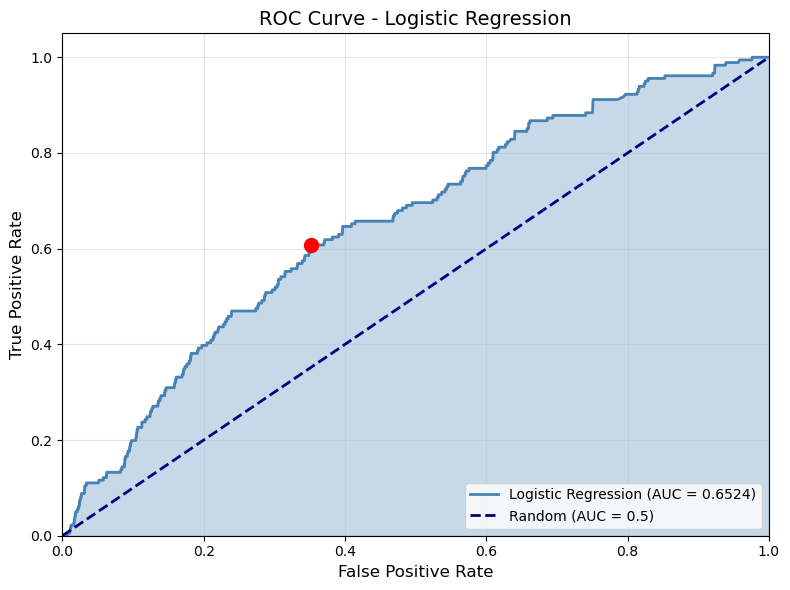

Optimal threshold: 0.5008


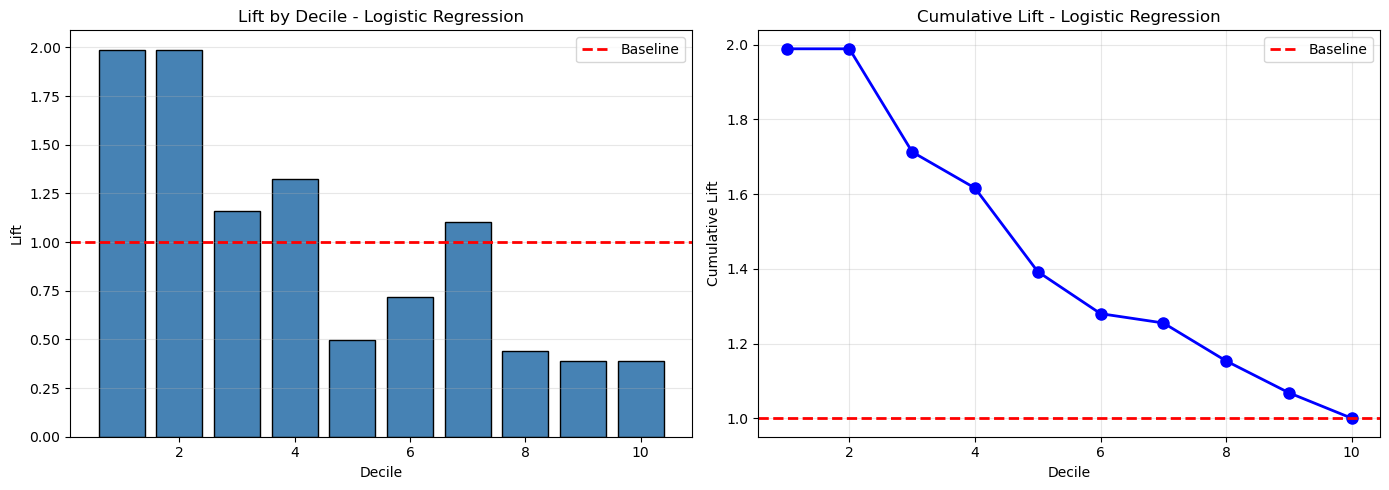

Top Decile Lift: 1.99x


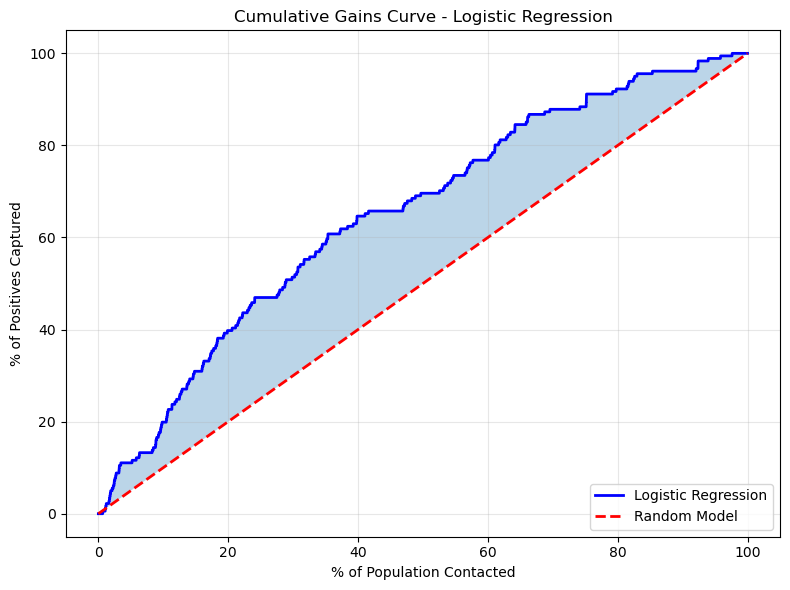

Top 10% captures 19.9% of positives
Top 20% captures 39.8% of positives
Top 30% captures 51.4% of positives
Top 50% captures 69.6% of positives


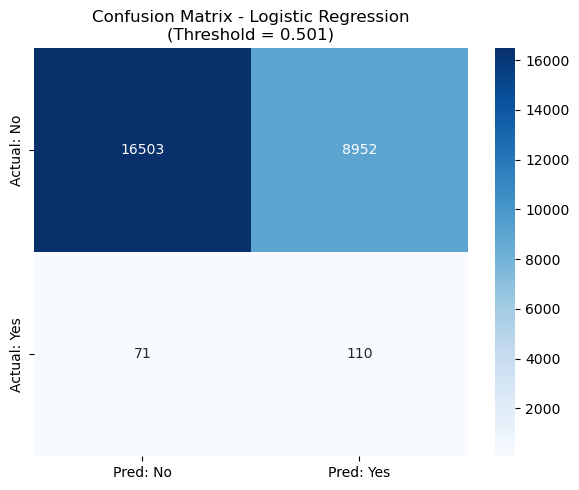


Classification Report (Threshold = 0.501):
              precision    recall  f1-score   support

 No Donation       1.00      0.65      0.79     25455
    Donation       0.01      0.61      0.02       181

    accuracy                           0.65     25636
   macro avg       0.50      0.63      0.40     25636
weighted avg       0.99      0.65      0.78     25636


LOGISTIC REGRESSION COMPLETE - AUC: 0.6524


In [1839]:
# ==============================================================================
# MODEL 1: LOGISTIC REGRESSION (Using Stepwise Features)
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("LOGISTIC REGRESSION MODEL (Stepwise Features)")
print("="*70)

# ------------------------------------------------------------------------------
# 1. Use Stepwise Selected Features
# ------------------------------------------------------------------------------
stepwise_features = ['max_amount', 'amount_per_letter', 'gender_M', 
                     'has_donated_30_plus', 'age_group_senior']

X_train_stepwise = X_train[stepwise_features]
X_val_stepwise = X_val[stepwise_features]

print(f"Features used: {stepwise_features}")
print(f"Training set: {X_train_stepwise.shape[0]} samples, {y_train.mean()*100:.2f}% positive")
print(f"Validation set: {X_val_stepwise.shape[0]} samples, {y_val.mean()*100:.2f}% positive")

# ------------------------------------------------------------------------------
# 2. Feature Scaling
# ------------------------------------------------------------------------------
scaler_lr = StandardScaler()
X_train_lr = scaler_lr.fit_transform(X_train_stepwise)
X_val_lr = scaler_lr.transform(X_val_stepwise)

# ------------------------------------------------------------------------------
# 3. Train Model
# ------------------------------------------------------------------------------
lr_model = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
lr_model.fit(X_train_lr, y_train)

# ------------------------------------------------------------------------------
# 4. Predictions
# ------------------------------------------------------------------------------
y_pred_proba_lr = lr_model.predict_proba(X_val_lr)[:, 1]

final_auc_lr = roc_auc_score(y_val, y_pred_proba_lr)
print(f"\n{'='*50}")
print(f"LOGISTIC REGRESSION - VALIDATION AUC: {final_auc_lr:.4f}")
print(f"{'='*50}")

# ------------------------------------------------------------------------------
# 5. ROC Curve
# ------------------------------------------------------------------------------
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_val, y_pred_proba_lr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_lr, tpr_lr, color='steelblue', lw=2, label=f'Logistic Regression (AUC = {final_auc_lr:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
ax.fill_between(fpr_lr, tpr_lr, alpha=0.3, color='steelblue')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Logistic Regression', fontsize=14)

optimal_idx_lr = np.argmax(tpr_lr - fpr_lr)
optimal_threshold_lr = thresholds_lr[optimal_idx_lr]
ax.scatter(fpr_lr[optimal_idx_lr], tpr_lr[optimal_idx_lr], marker='o', color='red', s=100, zorder=5)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal threshold: {optimal_threshold_lr:.4f}")

# ------------------------------------------------------------------------------
# 6. Lift Curve
# ------------------------------------------------------------------------------
def calculate_lift_curve(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    df['decile'] = pd.qcut(df.index, n_bins, labels=False, duplicates='drop') + 1
    overall_rate = df['y_true'].mean()
    lift_data = df.groupby('decile').agg({'y_true': ['sum', 'count', 'mean']}).reset_index()
    lift_data.columns = ['Decile', 'Positives', 'Total', 'Response_Rate']
    lift_data['Lift'] = lift_data['Response_Rate'] / overall_rate
    lift_data['Cumulative_Positives'] = lift_data['Positives'].cumsum()
    lift_data['Cumulative_Total'] = lift_data['Total'].cumsum()
    lift_data['Cumulative_Response_Rate'] = lift_data['Cumulative_Positives'] / lift_data['Cumulative_Total']
    lift_data['Cumulative_Lift'] = lift_data['Cumulative_Response_Rate'] / overall_rate
    return lift_data, overall_rate

lift_data_lr, overall_rate_lr = calculate_lift_curve(y_val.values, y_pred_proba_lr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(lift_data_lr['Decile'], lift_data_lr['Lift'], color='steelblue', edgecolor='black')
axes[0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0].set_xlabel('Decile')
axes[0].set_ylabel('Lift')
axes[0].set_title('Lift by Decile - Logistic Regression')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].plot(lift_data_lr['Decile'], lift_data_lr['Cumulative_Lift'], 'b-o', linewidth=2, markersize=8)
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[1].set_xlabel('Decile')
axes[1].set_ylabel('Cumulative Lift')
axes[1].set_title('Cumulative Lift - Logistic Regression')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Top Decile Lift: {lift_data_lr['Lift'].iloc[0]:.2f}x")

# ------------------------------------------------------------------------------
# 7. Cumulative Gains Curve
# ------------------------------------------------------------------------------
def calculate_cumulative_gains(y_true, y_prob):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    total_positives = df['y_true'].sum()
    df['cum_positives'] = df['y_true'].cumsum()
    df['pct_population'] = (df.index + 1) / len(df) * 100
    df['pct_positives_captured'] = df['cum_positives'] / total_positives * 100
    return pd.DataFrame({
        'pct_population': [0] + df['pct_population'].tolist(),
        'pct_positives_captured': [0] + df['pct_positives_captured'].tolist()
    })

gains_data_lr = calculate_cumulative_gains(y_val.values, y_pred_proba_lr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(gains_data_lr['pct_population'], gains_data_lr['pct_positives_captured'], 'b-', linewidth=2, label='Logistic Regression')
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Random Model')
ax.fill_between(gains_data_lr['pct_population'], gains_data_lr['pct_positives_captured'], gains_data_lr['pct_population'], alpha=0.3)
ax.set_xlabel('% of Population Contacted')
ax.set_ylabel('% of Positives Captured')
ax.set_title('Cumulative Gains Curve - Logistic Regression')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

for pct in [10, 20, 30, 50]:
    idx = int(len(gains_data_lr) * pct / 100)
    print(f"Top {pct}% captures {gains_data_lr['pct_positives_captured'].iloc[idx]:.1f}% of positives")

# ------------------------------------------------------------------------------
# 8. Confusion Matrix
# ------------------------------------------------------------------------------
y_pred_optimal_lr = (y_pred_proba_lr >= optimal_threshold_lr).astype(int)
cm_lr = confusion_matrix(y_val, y_pred_optimal_lr)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Pred: No', 'Pred: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
ax.set_title(f'Confusion Matrix - Logistic Regression\n(Threshold = {optimal_threshold_lr:.3f})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Threshold = {optimal_threshold_lr:.3f}):")
print(classification_report(y_val, y_pred_optimal_lr, target_names=['No Donation', 'Donation']))

print("\n" + "="*70)
print(f"LOGISTIC REGRESSION COMPLETE - AUC: {final_auc_lr:.4f}")
print("="*70)

## 3) KNN

K-NEAREST NEIGHBORS MODEL (Stepwise Features)
Features used: ['max_amount', 'amount_per_letter', 'gender_M', 'has_donated_30_plus', 'age_group_senior']
Training set: 34887 samples, 2.19% positive

Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best CV AUC: 0.8311
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 51, 'weights': 'distance'}

KNN - VALIDATION AUC: 0.5470


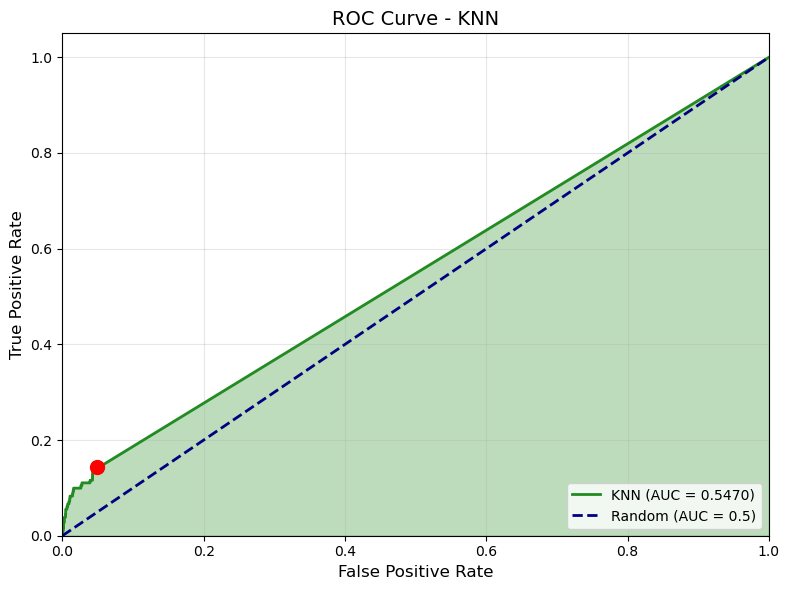

Optimal threshold: 0.0057


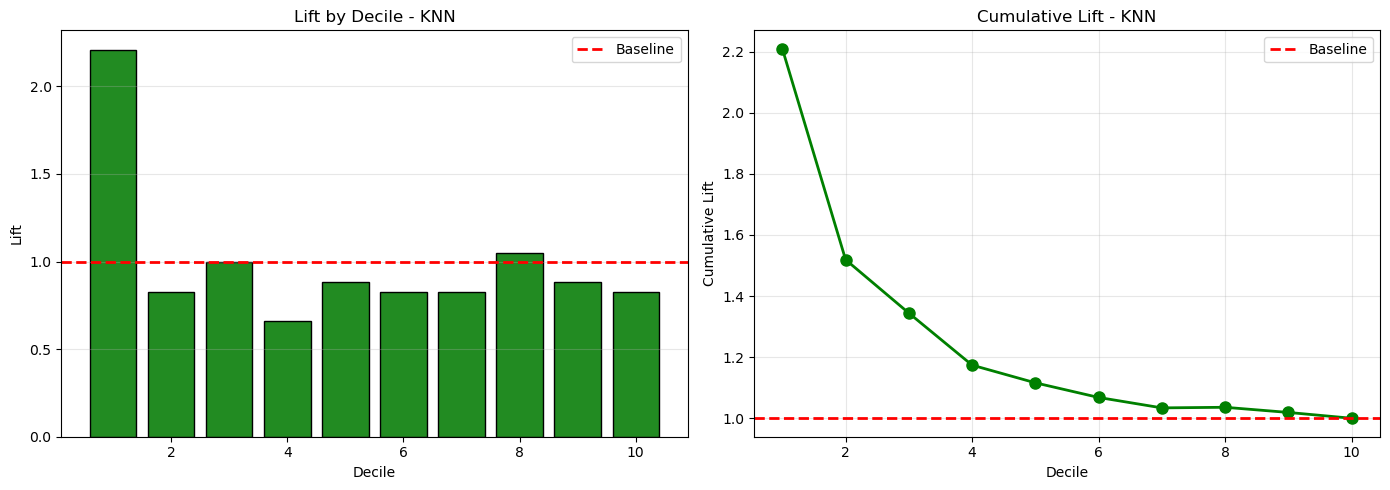

Top Decile Lift: 2.21x


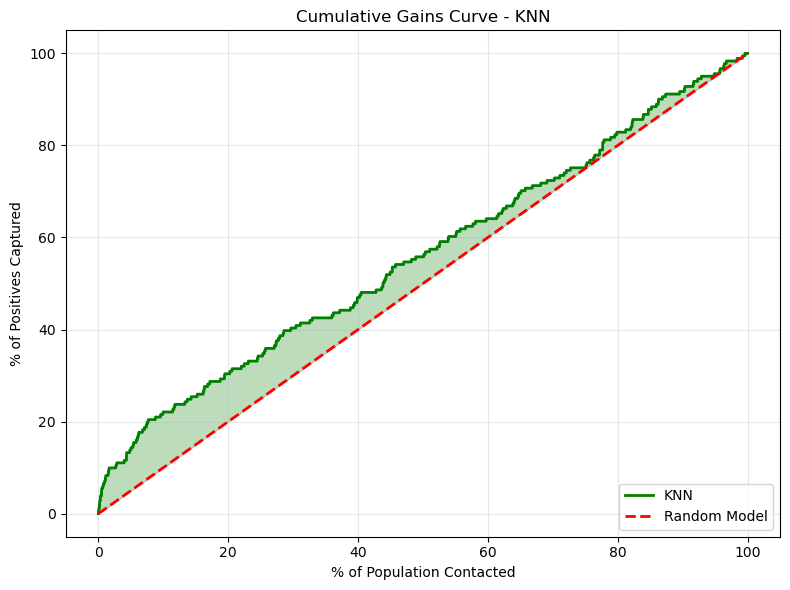

Top 10% captures 22.1% of positives
Top 20% captures 30.4% of positives
Top 30% captures 40.3% of positives
Top 50% captures 55.8% of positives


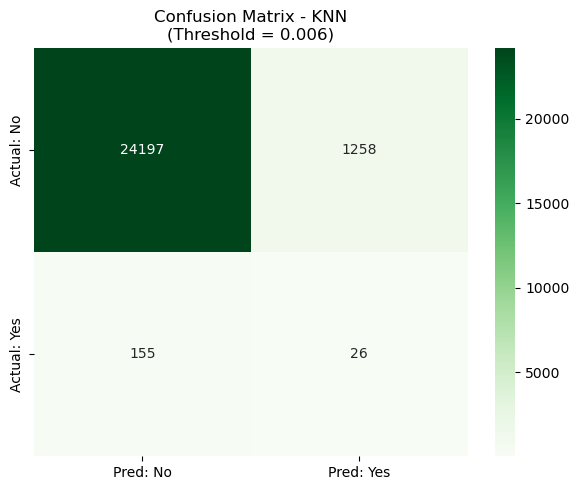


Classification Report (Threshold = 0.006):
              precision    recall  f1-score   support

 No Donation       0.99      0.95      0.97     25455
    Donation       0.02      0.14      0.04       181

    accuracy                           0.94     25636
   macro avg       0.51      0.55      0.50     25636
weighted avg       0.99      0.94      0.97     25636


KNN COMPLETE - AUC: 0.5470


In [1840]:
# ==============================================================================
# MODEL 2: KNN (Using Stepwise Features)
# ==============================================================================

print("="*70)
print("K-NEAREST NEIGHBORS MODEL (Stepwise Features)")
print("="*70)

# ------------------------------------------------------------------------------
# 1. Use Stepwise Selected Features
# ------------------------------------------------------------------------------
stepwise_features = ['max_amount', 'amount_per_letter', 'gender_M', 
                     'has_donated_30_plus', 'age_group_senior']

X_train_stepwise = X_train[stepwise_features]
X_val_stepwise = X_val[stepwise_features]

print(f"Features used: {stepwise_features}")
print(f"Training set: {X_train_stepwise.shape[0]} samples, {y_train.mean()*100:.2f}% positive")

# ------------------------------------------------------------------------------
# 2. Feature Scaling (Critical for KNN)
# ------------------------------------------------------------------------------
scaler_knn = StandardScaler()
X_train_knn = scaler_knn.fit_transform(X_train_stepwise)
X_val_knn = scaler_knn.transform(X_val_stepwise)

# ------------------------------------------------------------------------------
# 3. Hyperparameter Tuning
# ------------------------------------------------------------------------------
print("\nHyperparameter Tuning...")

param_grid = {
    'n_neighbors': [5, 11, 21, 31, 51],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_base = KNeighborsClassifier()

search_knn = GridSearchCV(
    estimator=knn_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

search_knn.fit(X_train_knn, y_train)

knn_model = search_knn.best_estimator_
print(f"\nBest CV AUC: {search_knn.best_score_:.4f}")
print(f"Best Parameters: {search_knn.best_params_}")

# ------------------------------------------------------------------------------
# 4. Predictions
# ------------------------------------------------------------------------------
y_pred_proba_knn = knn_model.predict_proba(X_val_knn)[:, 1]

final_auc_knn = roc_auc_score(y_val, y_pred_proba_knn)
print(f"\n{'='*50}")
print(f"KNN - VALIDATION AUC: {final_auc_knn:.4f}")
print(f"{'='*50}")

# ------------------------------------------------------------------------------
# 5. ROC Curve
# ------------------------------------------------------------------------------
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, y_pred_proba_knn)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_knn, tpr_knn, color='forestgreen', lw=2, label=f'KNN (AUC = {final_auc_knn:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
ax.fill_between(fpr_knn, tpr_knn, alpha=0.3, color='forestgreen')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - KNN', fontsize=14)

optimal_idx_knn = np.argmax(tpr_knn - fpr_knn)
optimal_threshold_knn = thresholds_knn[optimal_idx_knn]
ax.scatter(fpr_knn[optimal_idx_knn], tpr_knn[optimal_idx_knn], marker='o', color='red', s=100, zorder=5)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal threshold: {optimal_threshold_knn:.4f}")

# ------------------------------------------------------------------------------
# 6. Lift Curve
# ------------------------------------------------------------------------------
def calculate_lift_curve(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    df['decile'] = pd.qcut(df.index, n_bins, labels=False, duplicates='drop') + 1
    overall_rate = df['y_true'].mean()
    lift_data = df.groupby('decile').agg({'y_true': ['sum', 'count', 'mean']}).reset_index()
    lift_data.columns = ['Decile', 'Positives', 'Total', 'Response_Rate']
    lift_data['Lift'] = lift_data['Response_Rate'] / overall_rate
    lift_data['Cumulative_Positives'] = lift_data['Positives'].cumsum()
    lift_data['Cumulative_Total'] = lift_data['Total'].cumsum()
    lift_data['Cumulative_Response_Rate'] = lift_data['Cumulative_Positives'] / lift_data['Cumulative_Total']
    lift_data['Cumulative_Lift'] = lift_data['Cumulative_Response_Rate'] / overall_rate
    return lift_data, overall_rate

lift_data_knn, overall_rate_knn = calculate_lift_curve(y_val.values, y_pred_proba_knn)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(lift_data_knn['Decile'], lift_data_knn['Lift'], color='forestgreen', edgecolor='black')
axes[0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0].set_xlabel('Decile')
axes[0].set_ylabel('Lift')
axes[0].set_title('Lift by Decile - KNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].plot(lift_data_knn['Decile'], lift_data_knn['Cumulative_Lift'], 'g-o', linewidth=2, markersize=8)
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[1].set_xlabel('Decile')
axes[1].set_ylabel('Cumulative Lift')
axes[1].set_title('Cumulative Lift - KNN')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Top Decile Lift: {lift_data_knn['Lift'].iloc[0]:.2f}x")

# ------------------------------------------------------------------------------
# 7. Cumulative Gains Curve
# ------------------------------------------------------------------------------
def calculate_cumulative_gains(y_true, y_prob):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    total_positives = df['y_true'].sum()
    df['cum_positives'] = df['y_true'].cumsum()
    df['pct_population'] = (df.index + 1) / len(df) * 100
    df['pct_positives_captured'] = df['cum_positives'] / total_positives * 100
    return pd.DataFrame({
        'pct_population': [0] + df['pct_population'].tolist(),
        'pct_positives_captured': [0] + df['pct_positives_captured'].tolist()
    })

gains_data_knn = calculate_cumulative_gains(y_val.values, y_pred_proba_knn)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(gains_data_knn['pct_population'], gains_data_knn['pct_positives_captured'], 'g-', linewidth=2, label='KNN')
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Random Model')
ax.fill_between(gains_data_knn['pct_population'], gains_data_knn['pct_positives_captured'], gains_data_knn['pct_population'], alpha=0.3, color='forestgreen')
ax.set_xlabel('% of Population Contacted')
ax.set_ylabel('% of Positives Captured')
ax.set_title('Cumulative Gains Curve - KNN')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

for pct in [10, 20, 30, 50]:
    idx = int(len(gains_data_knn) * pct / 100)
    print(f"Top {pct}% captures {gains_data_knn['pct_positives_captured'].iloc[idx]:.1f}% of positives")

# ------------------------------------------------------------------------------
# 8. Confusion Matrix
# ------------------------------------------------------------------------------
y_pred_optimal_knn = (y_pred_proba_knn >= optimal_threshold_knn).astype(int)
cm_knn = confusion_matrix(y_val, y_pred_optimal_knn)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Pred: No', 'Pred: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
ax.set_title(f'Confusion Matrix - KNN\n(Threshold = {optimal_threshold_knn:.3f})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Threshold = {optimal_threshold_knn:.3f}):")
print(classification_report(y_val, y_pred_optimal_knn, target_names=['No Donation', 'Donation']))

print("\n" + "="*70)
print(f"KNN COMPLETE - AUC: {final_auc_knn:.4f}")
print("="*70)

## 4) Neural Network

NEURAL NETWORK (MLPClassifier) MODEL (Stepwise Features)
Features used: ['max_amount', 'amount_per_letter', 'gender_M', 'has_donated_30_plus', 'age_group_senior']
Training set: 34887 samples, 2.19% positive

Hyperparameter Tuning...
(Neural Network may take time depending on size...)
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best CV AUC: 0.7999
Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01, 'solver': 'adam'}

NEURAL NETWORK - VALIDATION AUC: 0.6610


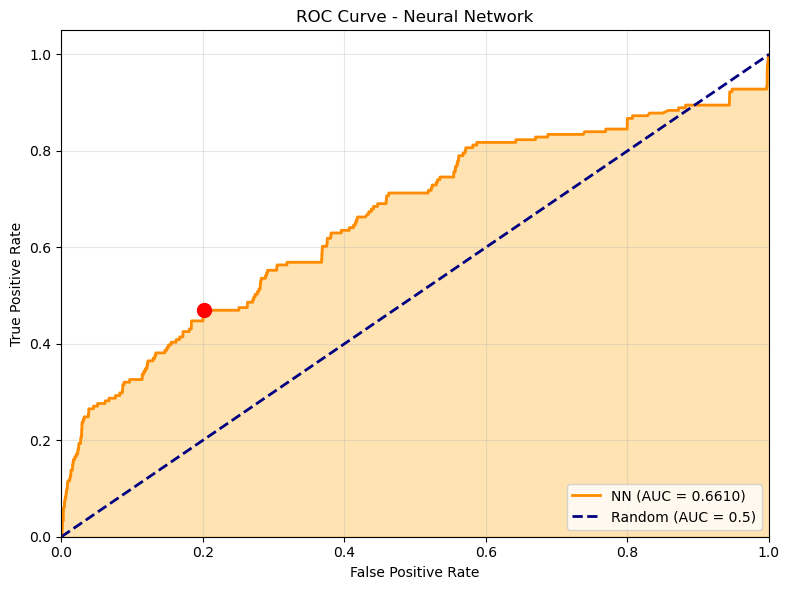

Optimal threshold: 0.0299


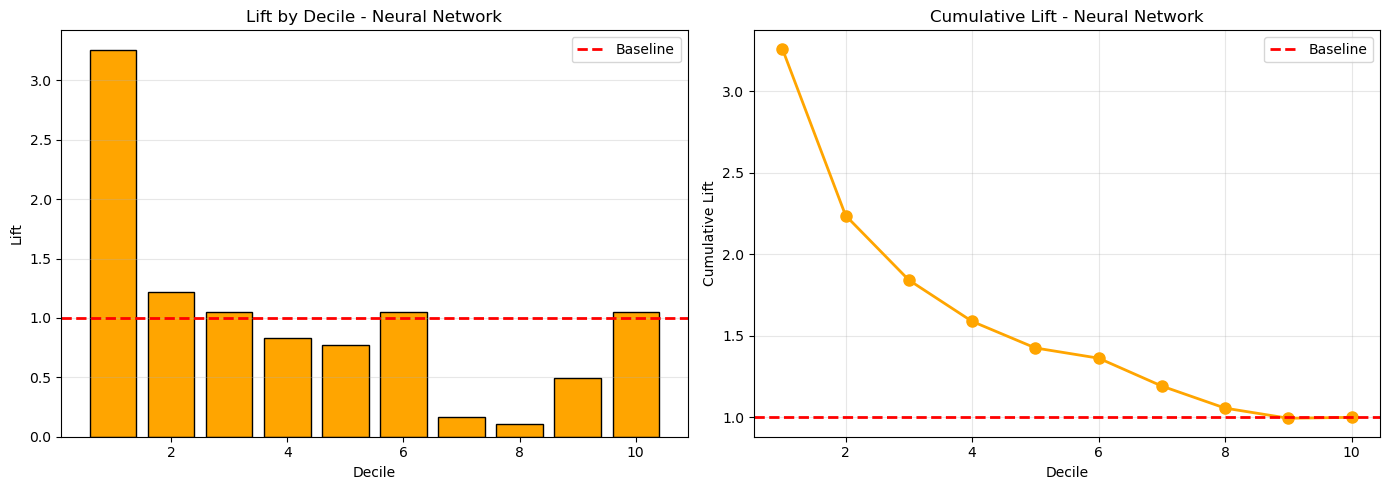

Top Decile Lift: 3.26x


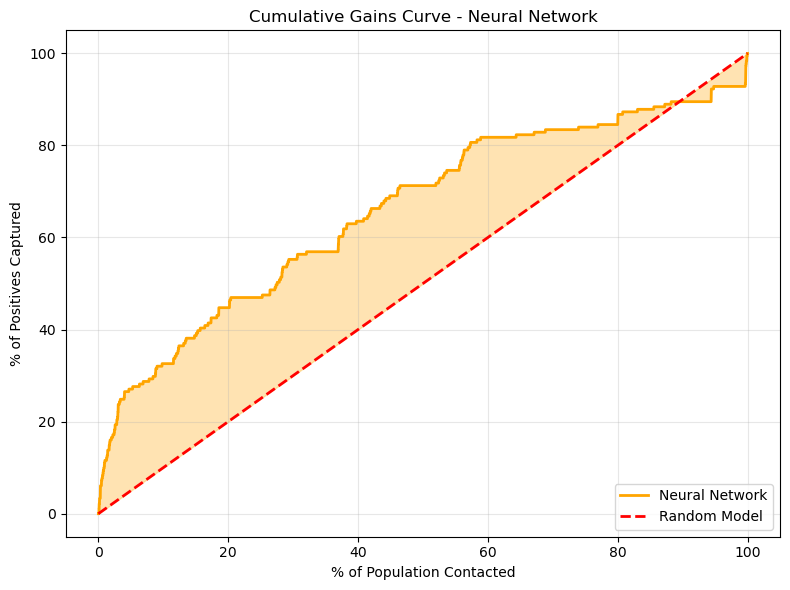

Top 10% captures 32.6% of positives
Top 20% captures 44.8% of positives
Top 30% captures 55.2% of positives
Top 50% captures 71.3% of positives


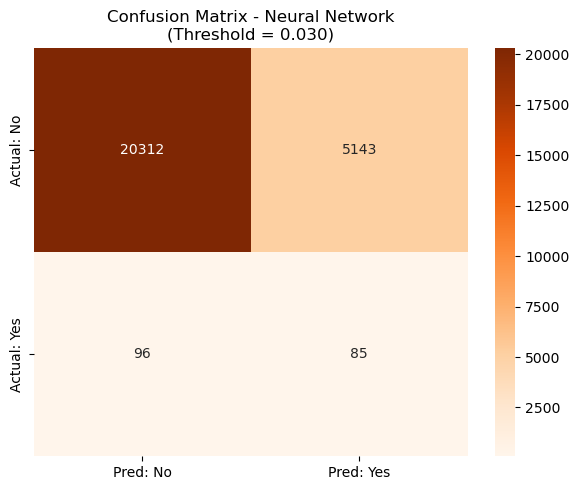


Classification Report (Threshold = 0.030):
              precision    recall  f1-score   support

 No Donation       1.00      0.80      0.89     25455
    Donation       0.02      0.47      0.03       181

    accuracy                           0.80     25636
   macro avg       0.51      0.63      0.46     25636
weighted avg       0.99      0.80      0.88     25636


NEURAL NETWORK COMPLETE - AUC: 0.6610


In [1841]:
# ==============================================================================
# MODEL 4: NEURAL NETWORK (MLPClassifier) USING STEPWISE FEATURES
# ==============================================================================

print("="*70)
print("NEURAL NETWORK (MLPClassifier) MODEL (Stepwise Features)")
print("="*70)

# ------------------------------------------------------------------------------
# 1. Use Stepwise Selected Features
# ------------------------------------------------------------------------------
stepwise_features = ['max_amount', 'amount_per_letter', 'gender_M', 
                     'has_donated_30_plus', 'age_group_senior']

X_train_stepwise = X_train[stepwise_features]
X_val_stepwise = X_val[stepwise_features]

print(f"Features used: {stepwise_features}")
print(f"Training set: {X_train_stepwise.shape[0]} samples, {y_train.mean()*100:.2f}% positive")

# ------------------------------------------------------------------------------
# 2. Feature Scaling (Critical for Neural Networks)
# ------------------------------------------------------------------------------
scaler_nn = StandardScaler()
X_train_nn = scaler_nn.fit_transform(X_train_stepwise)
X_val_nn = scaler_nn.transform(X_val_stepwise)

# ------------------------------------------------------------------------------
# 3. Hyperparameter Tuning
# ------------------------------------------------------------------------------
print("\nHyperparameter Tuning...")
print("(Neural Network may take time depending on size...)")

param_grid = {
    'hidden_layer_sizes': [(16,), (32,), (32,16), (64,32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
}

mlp_base = MLPClassifier(max_iter=500, random_state=42)

search_nn = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1,
    n_jobs=-1
)

search_nn.fit(X_train_nn, y_train)

nn_model = search_nn.best_estimator_
print(f"\nBest CV AUC: {search_nn.best_score_:.4f}")
print(f"Best Parameters: {search_nn.best_params_}")

# ------------------------------------------------------------------------------
# 4. Predictions
# ------------------------------------------------------------------------------
y_pred_proba_nn = nn_model.predict_proba(X_val_nn)[:, 1]

final_auc_nn = roc_auc_score(y_val, y_pred_proba_nn)
print(f"\n{'='*50}")
print(f"NEURAL NETWORK - VALIDATION AUC: {final_auc_nn:.4f}")
print(f"{'='*50}")

# ------------------------------------------------------------------------------
# 5. ROC Curve
# ------------------------------------------------------------------------------
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_val, y_pred_proba_nn)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'NN (AUC = {final_auc_nn:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
ax.fill_between(fpr_nn, tpr_nn, alpha=0.3, color='orange')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Neural Network')

optimal_idx_nn = np.argmax(tpr_nn - fpr_nn)
optimal_threshold_nn = thresholds_nn[optimal_idx_nn]
ax.scatter(fpr_nn[optimal_idx_nn], tpr_nn[optimal_idx_nn], marker='o', color='red', s=100, zorder=5)
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal threshold: {optimal_threshold_nn:.4f}")

# ------------------------------------------------------------------------------
# 6. Lift Curve
# ------------------------------------------------------------------------------
def calculate_lift_curve(y_true, y_prob, n_bins=10):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    df['decile'] = pd.qcut(df.index, n_bins, labels=False, duplicates='drop') + 1
    overall_rate = df['y_true'].mean()
    lift_data = df.groupby('decile').agg({'y_true': ['sum', 'count', 'mean']}).reset_index()
    lift_data.columns = ['Decile', 'Positives', 'Total', 'Response_Rate']
    lift_data['Lift'] = lift_data['Response_Rate'] / overall_rate
    lift_data['Cumulative_Positives'] = lift_data['Positives'].cumsum()
    lift_data['Cumulative_Total'] = lift_data['Total'].cumsum()
    lift_data['Cumulative_Response_Rate'] = lift_data['Cumulative_Positives'] / lift_data['Cumulative_Total']
    lift_data['Cumulative_Lift'] = lift_data['Cumulative_Response_Rate'] / overall_rate
    return lift_data, overall_rate

lift_data_nn, overall_rate_nn = calculate_lift_curve(y_val.values, y_pred_proba_nn)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(lift_data_nn['Decile'], lift_data_nn['Lift'], color='orange', edgecolor='black')
axes[0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0].set_xlabel('Decile')
axes[0].set_ylabel('Lift')
axes[0].set_title('Lift by Decile - Neural Network')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].plot(lift_data_nn['Decile'], lift_data_nn['Cumulative_Lift'], 'orange', marker='o', linewidth=2, markersize=8)
axes[1].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[1].set_xlabel('Decile')
axes[1].set_ylabel('Cumulative Lift')
axes[1].set_title('Cumulative Lift - Neural Network')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Top Decile Lift: {lift_data_nn['Lift'].iloc[0]:.2f}x")

# ------------------------------------------------------------------------------
# 7. Cumulative Gains Curve
# ------------------------------------------------------------------------------
def calculate_cumulative_gains(y_true, y_prob):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    total_positives = df['y_true'].sum()
    df['cum_positives'] = df['y_true'].cumsum()
    df['pct_population'] = (df.index + 1) / len(df) * 100
    df['pct_positives_captured'] = df['cum_positives'] / total_positives * 100
    return pd.DataFrame({
        'pct_population': [0] + df['pct_population'].tolist(),
        'pct_positives_captured': [0] + df['pct_positives_captured'].tolist()
    })

gains_data_nn = calculate_cumulative_gains(y_val.values, y_pred_proba_nn)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(gains_data_nn['pct_population'], gains_data_nn['pct_positives_captured'], 'orange', linewidth=2, label='Neural Network')
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Random Model')
ax.fill_between(gains_data_nn['pct_population'], gains_data_nn['pct_positives_captured'], gains_data_nn['pct_population'], alpha=0.3, color='orange')
ax.set_xlabel('% of Population Contacted')
ax.set_ylabel('% of Positives Captured')
ax.set_title('Cumulative Gains Curve - Neural Network')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

for pct in [10, 20, 30, 50]:
    idx = int(len(gains_data_nn) * pct / 100)
    print(f"Top {pct}% captures {gains_data_nn['pct_positives_captured'].iloc[idx]:.1f}% of positives")

# ------------------------------------------------------------------------------
# 8. Confusion Matrix at Optimal Threshold
# ------------------------------------------------------------------------------
y_pred_optimal_nn = (y_pred_proba_nn >= optimal_threshold_nn).astype(int)
cm_nn = confusion_matrix(y_val, y_pred_optimal_nn)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Oranges', ax=ax,
            xticklabels=['Pred: No', 'Pred: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
ax.set_title(f'Confusion Matrix - Neural Network\n(Threshold = {optimal_threshold_nn:.3f})')
plt.tight_layout()
plt.show()

print(f"\nClassification Report (Threshold = {optimal_threshold_nn:.3f}):")
print(classification_report(y_val, y_pred_optimal_nn, target_names=['No Donation', 'Donation']))

print("\n" + "="*70)
print(f"NEURAL NETWORK COMPLETE - AUC: {final_auc_nn:.4f}")
print("="*70)

# Models comparison

MODEL COMPARISON SUMMARY

--------------------------------------------------
AUC COMPARISON
--------------------------------------------------

Model                     Validation AUC  Rank
--------------------------------------------------
🏆 XGBoost                 0.7620          1
   NN                      0.6610          2
   Logistic Regression     0.6524          3
   KNN                     0.5470          4

✅ Best Model: XGBoost (AUC = 0.7620)

--------------------------------------------------
Combined ROC Curve
--------------------------------------------------


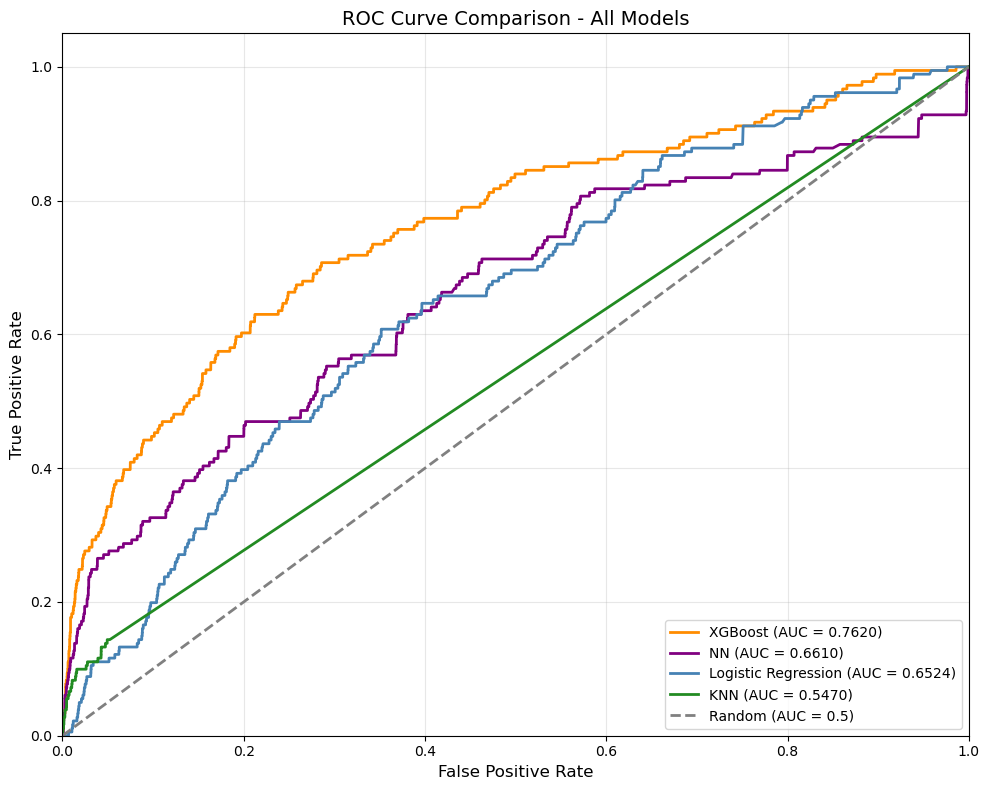

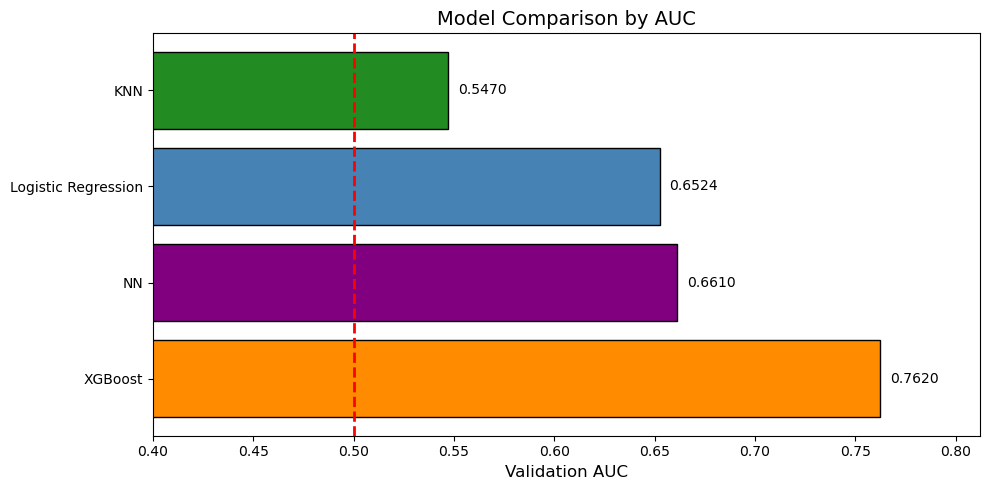


--------------------------------------------------
MODEL CHARACTERISTICS
--------------------------------------------------

┌─────────────────────┬──────────────┬─────────────┬──────────────┐
│ Model               │ Scaling Req? │ Speed       │ Interpretable│
├─────────────────────┼──────────────┼─────────────┼──────────────┤
│ XGBoost             │ No           │ Fast        │ Moderate     │
│ Logistic Regression │ Yes          │ Very Fast   │ High         │
│ KNN                 │ Yes          │ Slow (pred) │ Low          │
│ NN                  │ Yes          │ Very Slow   │ Low          │
└─────────────────────┴──────────────┴─────────────┴──────────────┘


RECOMMENDATION

Based on the results:

1. BEST PERFORMANCE: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=np.float64(0.7475884550556351),
              colsample_bynode=None,
              colsample_bytree=np.float64(0.5171942605576092), device=None,
              early_stopping_r

In [1842]:
# ==============================================================================
# MODEL COMPARISON SUMMARY
# ==============================================================================
# Run this AFTER running all 4 models (XGBoost, Logistic Regression, KNN, NN)
# ==============================================================================

print("="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

# ------------------------------------------------------------------------------
# Collect results (adjust variable names if different)
# ------------------------------------------------------------------------------
models = {
    'XGBoost': {
        'auc': final_auc,  # From your XGBoost model
        'color': 'darkorange',
        'fpr': fpr,
        'tpr': tpr
    },
    'Logistic Regression': {
        'auc': final_auc_lr,
        'color': 'steelblue',
        'fpr': fpr_lr,
        'tpr': tpr_lr
    },
    'KNN': {
        'auc': final_auc_knn,
        'color': 'forestgreen',
        'fpr': fpr_knn,
        'tpr': tpr_knn
    },
    'NN': {
        'auc': final_auc_nn,
        'color': 'purple',
        'fpr': fpr_nn,
        'tpr': tpr_nn
    }
}

# ------------------------------------------------------------------------------
# 1. AUC Comparison Table
# ------------------------------------------------------------------------------
print("\n" + "-"*50)
print("AUC COMPARISON")
print("-"*50)

print(f"\n{'Model':<25} {'Validation AUC':<15} {'Rank'}")
print("-"*50)

sorted_models = sorted(models.items(), key=lambda x: x[1]['auc'], reverse=True)
for rank, (name, data) in enumerate(sorted_models, 1):
    marker = "🏆" if rank == 1 else "  "
    print(f"{marker} {name:<23} {data['auc']:.4f}          {rank}")

best_model_name = sorted_models[0][0]  # Change variable name here
best_auc = sorted_models[0][1]['auc']
print(f"\n✅ Best Model: {best_model_name} (AUC = {best_auc:.4f})")

# ------------------------------------------------------------------------------
# 2. Combined ROC Curve
# ------------------------------------------------------------------------------
print("\n" + "-"*50)
print("Combined ROC Curve")
print("-"*50)

fig, ax = plt.subplots(figsize=(10, 8))

for name, data in sorted_models:
    ax.plot(data['fpr'], data['tpr'], color=data['color'], lw=2, 
            label=f"{name} (AUC = {data['auc']:.4f})")

ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.5)')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison - All Models', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 3. AUC Bar Chart
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

names = [name for name, _ in sorted_models]
aucs = [data['auc'] for _, data in sorted_models]
colors = [data['color'] for _, data in sorted_models]

bars = ax.barh(names, aucs, color=colors, edgecolor='black')
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Random')
ax.set_xlabel('Validation AUC', fontsize=12)
ax.set_title('Model Comparison by AUC', fontsize=14)
ax.set_xlim([0.4, max(aucs) + 0.05])

# Add value labels
for bar, auc in zip(bars, aucs):
    ax.text(auc + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{auc:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------------------
# 4. Model Characteristics Summary
# ------------------------------------------------------------------------------
print("\n" + "-"*50)
print("MODEL CHARACTERISTICS")
print("-"*50)

print("""
┌─────────────────────┬──────────────┬─────────────┬──────────────┐
│ Model               │ Scaling Req? │ Speed       │ Interpretable│
├─────────────────────┼──────────────┼─────────────┼──────────────┤
│ XGBoost             │ No           │ Fast        │ Moderate     │
│ Logistic Regression │ Yes          │ Very Fast   │ High         │
│ KNN                 │ Yes          │ Slow (pred) │ Low          │
│ NN                  │ Yes          │ Very Slow   │ Low          │
└─────────────────────┴──────────────┴─────────────┴──────────────┘
""")

# ------------------------------------------------------------------------------
# 5. Recommendation
# ------------------------------------------------------------------------------
print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

print(f"""
Based on the results:

1. BEST PERFORMANCE: {best_model} with AUC = {best_auc:.4f}

2. For PRODUCTION deployment:
   - If interpretability matters: Logistic Regression
   - If only performance matters: XGBoost
   
3. KNN and SVM are generally NOT recommended for this problem because:
   - Imbalanced data (only ~2% positive class)
   - Large dataset (slow training/prediction)
   - No significant performance advantage

4. XGBoost advantages for this problem:
   - Handles imbalance well (scale_pos_weight)
   - Captures non-linear patterns
   - Built-in feature selection
   - Fast training with early stopping
""")

print("="*70)

# Final basetable_test + scoring

In [1843]:
# ==============================================================================
# COMPLETE SCRIPT: SCORE TEST SET & EXPORT TO EXCEL
# ==============================================================================
# Run this AFTER you have:
# 1. Trained your XGBoost model (best_model)
# 2. Have X_train, y_val, y_pred_proba from validation
# 3. Loaded donors, gifts, camp dataframes
# ==============================================================================

# ==============================================================================
# STEP 1: DEFINE THE CREATE_BASETABLE FUNCTION (CORRECTED)
# ==============================================================================

def create_basetable(selection_campaign_df, donors, gifts, camp, campaign_date, 
                     donation_threshold=donation, look_back_days=look_back, 
                     training_columns=None):
    """
    Creates a basetable for a new campaign selection.
    """
    
    print(f"Building basetable for campaign on {campaign_date.date()}")
    print(f"Number of donors in selection: {len(selection_campaign_df)}")
    
    # Step 1: Prepare gifts data
    gifts = gifts.copy()
    gifts['gift_date'] = pd.to_datetime(gifts['gift_date'])
    gifts_before = gifts[gifts['gift_date'] < campaign_date].copy()
    campaign_donors = selection_campaign_df['donorID'].unique()
    gifts_campaign = gifts_before[gifts_before['donorID'].isin(campaign_donors)]
    start_date = campaign_date - pd.Timedelta(days=look_back_days)
    gifts_window = gifts_campaign[gifts_campaign['gift_date'] >= start_date]
    
    print(f"Gifts in lookback window: {len(gifts_window)}")
    
    # Step 2: Create Demographic Features
    donors = donors.copy()
    donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'], errors='coerce') # Handle invalid dates
    features = selection_campaign_df.merge(donors, on='donorID', how='left')
    
    # --- FIX START: Handle Missing Ages ---
    # Calculate age as float first
    features['age'] = (campaign_date - features['dateOfBirth']).dt.days / 365.25
    
    # Fill missing ages with 0 (or you could use mean like 45) so we can convert to int
    features['age'] = features['age'].fillna(0).astype(int)
    # --- FIX END ---

    features['age_group'] = features['age'].apply(
        lambda x: 'youth' if x <= 25 
        else ('adult' if x > 25 and x < 40 
              else ('middle_aged' if x >= 40 and x < 65 
                    else 'senior'))
    )
    
    # Step 3: Create RFM Features
    rfm = gifts_window.groupby('donorID').agg(
        first_gift=('gift_date', 'min'),
        last_gift=('gift_date', 'max'),
        frequency=('amount', 'count'),
        total_amount=('amount', 'sum'),
        avg_amount=('amount', 'mean'),
        max_amount=('amount', 'max'),
        min_amount=('amount', 'min')
    ).reset_index()
    
    rfm['recency_days'] = (campaign_date - rfm['last_gift']).dt.days
    rfm['LOR'] = (rfm['last_gift'] - rfm['first_gift']).dt.days
    rfm = rfm.drop(columns=['first_gift', 'last_gift'])
    
    # Step 4: Create Donation Pattern Features
    std_amount = gifts_window.groupby('donorID')['amount'].std().reset_index()
    std_amount.columns = ['donorID', 'std_amount']
    rfm = rfm.merge(std_amount, on='donorID', how='left')
    rfm['std_amount'] = rfm['std_amount'].fillna(0)
    
    donor_max_threshold = gifts_window.groupby('donorID')['amount'].apply(
        lambda x: (x >= donation_threshold).any()
    ).reset_index()
    donor_max_threshold.columns = ['donorID', 'has_donated_30_plus']
    rfm = rfm.merge(donor_max_threshold, on='donorID', how='left')
    rfm['has_donated_30_plus'] = rfm['has_donated_30_plus'].fillna(False).astype(int)
    
    pct_above = gifts_window.groupby('donorID')['amount'].apply(
        lambda x: (x >= donation_threshold).sum() / len(x)
    ).reset_index()
    pct_above.columns = ['donorID', 'pct_donations_above_30']
    rfm = rfm.merge(pct_above, on='donorID', how='left')
    
    spontaneous = gifts_window.groupby('donorID').apply(
        lambda x: (x['campaignID'] == 0).sum() / len(x) if len(x) > 0 else 0
    ).reset_index()
    spontaneous.columns = ['donorID', 'spontaneous_donation_rate']
    rfm = rfm.merge(spontaneous, on='donorID', how='left')
    
    def avg_days_between(group):
        if len(group) < 2:
            return np.nan
        dates = group.sort_values()
        return dates.diff().dt.days.mean()
    
    avg_interval = gifts_window.groupby('donorID')['gift_date'].apply(avg_days_between).reset_index()
    avg_interval.columns = ['donorID', 'avg_days_between_donations']
    rfm = rfm.merge(avg_interval, on='donorID', how='left')
    
    def donation_trend(group):
        if len(group) < 2:
            return 0
        group = group.sort_values('gift_date')
        x = np.arange(len(group))
        y = group['amount'].values
        if np.std(y) == 0:
            return 0
        slope = np.polyfit(x, y, 1)[0]
        return slope
    
    trend = gifts_window.groupby('donorID').apply(donation_trend).reset_index()
    trend.columns = ['donorID', 'donation_trend']
    rfm = rfm.merge(trend, on='donorID', how='left')
    
    features = features.merge(rfm, on='donorID', how='left')
    features['has_no_donation_history'] = features['frequency'].isna().astype(int)
    
    # Step 5: Create Campaign Features
    gifts_with_camp = gifts_window.merge(
        camp[['campaignID', 'CostUnit', 'lettersSent']], 
        on='campaignID', 
        how='left'
    )
    
    campaign_features = gifts_with_camp.groupby('donorID').agg(
        CostUnit_mean=('CostUnit', 'mean'),
        CostUnit_min=('CostUnit', 'min'),
        CostUnit_max=('CostUnit', 'max'),
        lettersSent_mean=('lettersSent', 'mean')
    ).reset_index()
    
    campaign_features['CostUnit_range'] = (
        campaign_features['CostUnit_max'] - campaign_features['CostUnit_min']
    )
    
    features = features.merge(campaign_features, on='donorID', how='left')
    
    # Step 6: Create Derived Features
    features['amount_per_letter'] = (
        features['total_amount'] / (features['lettersSent_mean'] + 1)
    )
    features['gifts_per_year'] = (
        features['frequency'] / (features['LOR'] / 365 + 1)
    )
    features['current_value_ratio'] = (
        features['max_amount'] / (features['avg_amount'] + 1)
    )
    
    # Step 7: One-Hot Encode
    if 'zipcode' in features.columns:
        features = features.drop(columns=['zipcode'])
    
    cat_cols = ['province', 'region', 'gender', 'language', 'age_group']
    cat_cols = [c for c in cat_cols if c in features.columns]
    features = pd.get_dummies(features, columns=cat_cols, drop_first=True)
    
    bool_cols = features.select_dtypes(include='bool').columns
    features[bool_cols] = features[bool_cols].astype(int)
    
    # Step 8: Handle Missing Values
    if 'dateOfBirth' in features.columns:
        features = features.drop(columns=['dateOfBirth'])
    
    numeric_cols = features.select_dtypes(include=[np.number]).columns
    features[numeric_cols] = features[numeric_cols].fillna(0)
    
    # Step 9: Align Columns with Training Data
    if training_columns is not None:
        for col in training_columns:
            if col not in features.columns and col != 'target':
                features[col] = 0
        
        cols_to_keep = ['donorID'] + [c for c in training_columns if c != 'target']
        cols_to_keep = [c for c in cols_to_keep if c in features.columns]
        features = features[cols_to_keep]
    
    print(f"Final basetable shape: {features.shape}")
    
    return features


# ==============================================================================
# STEP 2: LOAD TEST CAMPAIGN DATA
# ==============================================================================
# IMPORTANT: Update the path and campaign date!

print("\n" + "="*70)
print("STEP 2: Loading test campaign data...")
print("="*70)

# Load the test campaign selection file
# UPDATE THIS PATH to your actual file!
sc_test = pd.read_csv('../data/raw/selection campaign 7362.csv')

# Set the campaign date for 7362
# UPDATE THIS DATE to the actual campaign date!
# You can find this in the campaigns.csv file or project brief
campaign_date_test = pd.to_datetime('2020-03-15')  # <-- UPDATE THIS!

print(f"Test campaign donors: {len(sc_test)}")
print(f"Campaign date: {campaign_date_test.date()}")


# ==============================================================================
# STEP 3: CREATE THE TEST BASETABLE
# ==============================================================================

print("\n" + "="*70)
print("STEP 3: Creating test basetable...")
print("="*70)

# Get training columns from your existing basetable
training_columns = basetable_train.columns.tolist()

# Create the test basetable
basetable_test = create_basetable(
    selection_campaign_df=sc_test,
    donors=donors,
    gifts=gifts,
    camp=camp,
    campaign_date=campaign_date_test,
    donation_threshold=30,
    look_back_days=6575,
    training_columns=training_columns
)

print(f"\nBasetable test created with shape: {basetable_test.shape}")


# ==============================================================================
# STEP 4: FIND OPTIMAL CUT-OFF FROM VALIDATION DATA
# ==============================================================================

print("\n" + "="*70)
print("STEP 4: Finding optimal cut-off from validation data...")
print("="*70)

def find_optimal_cutoff(y_val, y_pred_proba_val, cost_per_letter=0.80, revenue_per_donor=30):
    """
    Finds the optimal probability cut-off that maximizes profit.
    """
    df = pd.DataFrame({
        'y_true': y_val,
        'y_prob': y_pred_proba_val
    }).sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    total_population = len(df)
    
    best_profit = float('-inf')
    best_cutoff = 0
    best_pct = 0
    
    for pct in range(1, 101):
        n_contact = int(total_population * pct / 100)
        donors_captured = df['y_true'].iloc[:n_contact].sum()
        
        cost = n_contact * cost_per_letter
        revenue = donors_captured * revenue_per_donor
        profit = revenue - cost
        
        if profit > best_profit:
            best_profit = profit
            best_pct = pct
            best_cutoff = df['y_prob'].iloc[n_contact - 1] if n_contact > 0 else 1.0
    
    print(f"Optimal contact percentage: {best_pct}%")
    print(f"Probability cut-off: {best_cutoff:.6f}")
    print(f"Maximum profit: €{best_profit:,.2f}")
    
    return best_cutoff, best_pct, best_profit

# Find optimal cut-off using validation data
# NOTE: y_pred_proba should be your validation predictions from XGBoost
optimal_cutoff, optimal_pct, max_profit = find_optimal_cutoff(
    y_val.values, 
    y_pred_proba,  # <-- This is from your XGBoost model predictions on validation set
    cost_per_letter=0.80,
    revenue_per_donor=30
)


# ==============================================================================
# STEP 5: PREPARE TEST FEATURES AND GENERATE PREDICTIONS
# ==============================================================================

print("\n" + "="*70)
print("STEP 5: Scoring test set...")
print("="*70)

# Prepare test features
X_test = basetable_test.drop(columns=['donorID']).select_dtypes(include=[np.number])
X_test = X_test.fillna(0)

# Align columns with training data
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X_train.columns]

print(f"Test features shape: {X_test.shape}")

# Generate predictions using your trained XGBoost model
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]

print(f"Predictions generated for {len(y_pred_proba_test)} donors")


# ==============================================================================
# STEP 6: CREATE OUTPUT DATAFRAME WITH CUT-OFF DECISION
# ==============================================================================

print("\n" + "="*70)
print("STEP 6: Creating output with contact decisions...")
print("="*70)

# Create the output dataframe
output_df = pd.DataFrame({
    'donorID': basetable_test['donorID'],
    'predicted_probability': y_pred_proba_test,
    'contact': (y_pred_proba_test >= optimal_cutoff).astype(int)
})

# Sort by probability (highest first)
output_df = output_df.sort_values('predicted_probability', ascending=False).reset_index(drop=True)

# Add rank column
output_df['rank'] = range(1, len(output_df) + 1)

# Reorder columns
output_df = output_df[['rank', 'donorID', 'predicted_probability', 'contact']]

# Summary statistics
n_total = len(output_df)
n_contact = output_df['contact'].sum()
n_no_contact = n_total - n_contact

print(f"Total donors: {n_total:,}")
print(f"Donors to contact (contact=1): {n_contact:,} ({n_contact/n_total*100:.1f}%)")
print(f"Donors NOT to contact (contact=0): {n_no_contact:,} ({n_no_contact/n_total*100:.1f}%)")
print(f"Probability cut-off used: {optimal_cutoff:.6f}")


# ==============================================================================
# STEP 7: EXPORT TO EXCEL
# ==============================================================================

print("\n" + "="*70)
print("STEP 7: Exporting to Excel...")
print("="*70)

output_filename = 'scored_donors_campaign_7362.xlsx'

with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
    # Main data sheet
    output_df.to_excel(writer, sheet_name='Scored Donors', index=False)
    
    # Summary sheet
    summary_data = {
        'Metric': [
            'Total Donors',
            'Donors to Contact (contact=1)',
            'Donors NOT to Contact (contact=0)',
            'Contact Percentage',
            'Probability Cut-off',
            'Min Probability',
            'Max Probability',
            'Mean Probability',
            'Expected Cost (€0.80/letter)',
            'Optimal Profit (from validation)',
            'Note'
        ],
        'Value': [
            n_total,
            n_contact,
            n_no_contact,
            f"{n_contact/n_total*100:.1f}%",
            f"{optimal_cutoff:.6f}",
            f"{output_df['predicted_probability'].min():.6f}",
            f"{output_df['predicted_probability'].max():.6f}",
            f"{output_df['predicted_probability'].mean():.6f}",
            f"€{n_contact * 0.80:,.2f}",
            f"€{max_profit:,.2f}",
            'contact=1 means send letter, contact=0 means do not send'
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"\n✅ Excel file saved: '{output_filename}'")
print("\nFile contains 2 sheets:")
print("  1. 'Scored Donors' - All donors with probabilities and contact decisions")
print("  2. 'Summary' - Key statistics and cut-off information")


# ==============================================================================
# STEP 8: PREVIEW THE OUTPUT
# ==============================================================================

print("\n" + "="*70)
print("PREVIEW: Top 10 donors to contact")
print("="*70)
print(output_df.head(10).to_string(index=False))

print("\n" + "="*70)
print("PREVIEW: Donors around the cut-off threshold")
print("="*70)
# Show donors around the threshold
around_threshold = output_df[
    (output_df['predicted_probability'] >= optimal_cutoff * 0.9) & 
    (output_df['predicted_probability'] <= optimal_cutoff * 1.1)
].head(10)
print(around_threshold.to_string(index=False))

print("\n" + "="*70)
print("DONE!")
print("="*70)


STEP 2: Loading test campaign data...
Test campaign donors: 26522
Campaign date: 2020-03-15

STEP 3: Creating test basetable...
Building basetable for campaign on 2020-03-15
Number of donors in selection: 26522
Gifts in lookback window: 129385
Final basetable shape: (26522, 43)

Basetable test created with shape: (26522, 43)

STEP 4: Finding optimal cut-off from validation data...
Optimal contact percentage: 2%
Probability cut-off: 0.500841
Maximum profit: €940.40

STEP 5: Scoring test set...
Test features shape: (26522, 42)
Predictions generated for 26522 donors

STEP 6: Creating output with contact decisions...
Total donors: 26,522
Donors to contact (contact=1): 1,539 (5.8%)
Donors NOT to contact (contact=0): 24,983 (94.2%)
Probability cut-off used: 0.500841

STEP 7: Exporting to Excel...

✅ Excel file saved: 'scored_donors_campaign_7362.xlsx'

File contains 2 sheets:
  1. 'Scored Donors' - All donors with probabilities and contact decisions
  2. 'Summary' - Key statistics and cut-o

# Business application

Full concatenated business report:
                    XGBOOST MODEL BUSINESS ANALYSIS
______________________________________________________________________
Business interpretation --> quantifying the value
______________________________________________________________________
Assumptions:
  - Cost per letter: €0.80
  - Expected donation amount: €30
  - Total population: 25,636
  - Total actual donors: 181

  Using XGBoost Model (AUC: 0.7620)
____________________________________________________________
Random approach (contacting everyone)
____________________________________________________________
  • Letters: 25,636
  • Cost: 25,636 × €0.80 = €20,509
  • Donors: 181
  • Revenue: 181 × €30 = €5,430
  • Profit/Loss: €5,430 - €20,509 = €-15,079
____________________________________________________________
Scenario with the XGBoost model
______________________________
Scenario Analysis Table (XGBoost):
_____________________________________________________________________________________

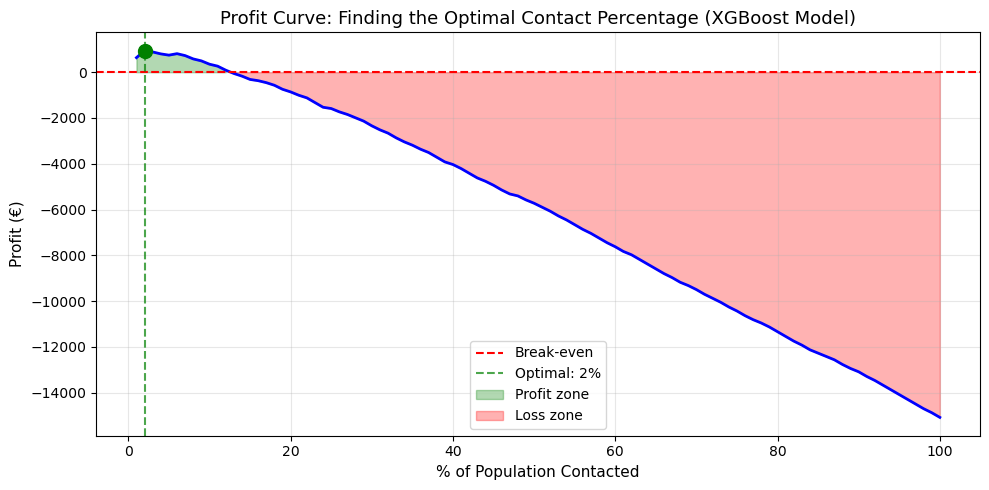

In [1847]:
# Again, concatenating the whole code to one cell allows for a smoother result in the output
print('Full concatenated business report:')
print('='*70)
print('                    XGBOOST MODEL BUSINESS ANALYSIS')
print('='*70)

# Business interpretation
print("_"*70)
print("Business interpretation --> quantifying the value")
print("_"*70)

cost_per_letter = 0.80  # €0.80 per letter as stated in project
avg_donation = donation  # donation is in the references at the top of the notebook (more convenient to test different levels to see how the model reacts)

total_population = len(y_val)
total_positives = int(y_val.sum())

print(f"Assumptions:")
print(f"  - Cost per letter: €{cost_per_letter:.2f}")
print(f"  - Expected donation amount: €{avg_donation:.0f}")
print(f"  - Total population: {total_population:,}")
print(f"  - Total actual donors: {total_positives}")

# -----------------------------------------------------------------------
# EXPLICITLY RECALCULATE GAINS DATA USING XGBOOST PREDICTIONS
# -----------------------------------------------------------------------
# Use the XGBoost model's predictions (best_model from XGBoost section)
y_pred_proba_xgb = best_model.predict_proba(X_val)[:, 1]

def calculate_cumulative_gains(y_true, y_prob):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    total_positives = df['y_true'].sum()
    total_samples = len(df)
    
    df['cum_positives'] = df['y_true'].cumsum()
    df['pct_population'] = (df.index + 1) / total_samples * 100
    df['pct_positives_captured'] = df['cum_positives'] / total_positives * 100
    
    gains_data = pd.DataFrame({
        'pct_population': [0] + df['pct_population'].tolist(),
        'pct_positives_captured': [0] + df['pct_positives_captured'].tolist()
    })
    
    return gains_data

# Recalculate gains_data explicitly using XGBoost predictions
gains_data_xgb = calculate_cumulative_gains(y_val.values, y_pred_proba_xgb)

print(f"\n  Using XGBoost Model (AUC: {roc_auc_score(y_val, y_pred_proba_xgb):.4f})")

# -------------------------------------------------------------------------------------------------------
# Random approach (if we contact everyone)
print("_"*60)
print("Random approach (contacting everyone)")
print("_"*60)

random_letters = total_population
random_cost = random_letters * cost_per_letter
random_donors = total_positives
random_revenue = random_donors * avg_donation
random_profit = random_revenue - random_cost

print(f"  • Letters: {random_letters:,}")
print(f"  • Cost: {random_letters:,} × €{cost_per_letter:.2f} = €{random_cost:,.0f}")
print(f"  • Donors: {random_donors}")
print(f"  • Revenue: {random_donors} × €{avg_donation:.0f} = €{random_revenue:,.0f}")
print(f"  • Profit/Loss: €{random_revenue:,.0f} - €{random_cost:,.0f} = €{random_profit:,.0f}")

# -------------------------------------------------------------------------------------------------------
# Model approach --> scenario with the model
print("_"*60)
print("Scenario with the XGBoost model")
print("_"*30)

# Test different percentages to find optimal
best_profit = float('-inf')
best_pct = 0
results_table = []

for pct in [1, 2, 2.5, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]:
    n_contacted = int(total_population * pct / 100)
    idx = min(int(len(gains_data_xgb) * pct / 100), len(gains_data_xgb) - 1)
    captured_pct = gains_data_xgb['pct_positives_captured'].iloc[idx] / 100
    n_donations = int(total_positives * captured_pct)
    
    revenue = n_donations * avg_donation
    cost = n_contacted * cost_per_letter
    profit = revenue - cost
    
    results_table.append({
        'Pct_Contacted': pct,
        'Letters': n_contacted,
        'Cost': cost,
        'Donors_Captured': n_donations,
        'Pct_Donors_Captured': captured_pct * 100,
        'Revenue': revenue,
        'Profit': profit
    })
    
    if profit > best_profit:
        best_profit = profit
        best_pct = pct

results_df = pd.DataFrame(results_table)

# -------------------------------------------------------------------------------------------------------
# Scenario analysis table

# Show the results table
print("Scenario Analysis Table (XGBoost):")
print("_"*90)
print(f"{'%Pop':>6} {'Letters':>8} {'Cost':>10} {'Donors':>7} {'%Captured':>10} {'Revenue':>10} {'Profit':>12}")
print("-"*90)
for _, row in results_df.iterrows():
    profit_str = f"€{row['Profit']:,.0f}" if row['Profit'] >= 0 else f"-€{abs(row['Profit']):,.0f}"
    print(f"{row['Pct_Contacted']:>5}% {row['Letters']:>8,} €{row['Cost']:>9,.0f} {row['Donors_Captured']:>7} {row['Pct_Donors_Captured']:>9.1f}% €{row['Revenue']:>9,.0f} {profit_str:>12}")


# -------------------------------------------------------------------------------------------------------
# Quantitative approach

# Optimal model approach
optimal_row = results_df[results_df['Pct_Contacted'] == best_pct].iloc[0]

print('_'*60)
print(f"Optimal XGBoost model approach (Contact Top {best_pct}%)")
print('_'*60)
print(' ')
print(f"  • Letters: {int(optimal_row['Letters']):,}")
print(f"  • Cost: {int(optimal_row['Letters']):,} × €{cost_per_letter:.2f} = €{optimal_row['Cost']:,.0f}")
print(f"  • Donors: ~{int(optimal_row['Donors_Captured'])} ({optimal_row['Pct_Donors_Captured']:.0f}% of {total_positives})")
print(f"  • Revenue: {int(optimal_row['Donors_Captured'])} × €{avg_donation:.0f} = €{optimal_row['Revenue']:,.0f}")

if optimal_row['Profit'] >= 0:
    print(f"  • Profit: €{optimal_row['Revenue']:,.0f} - €{optimal_row['Cost']:,.0f} = €{optimal_row['Profit']:,.0f}")
else:
    print(f"  • Loss: €{optimal_row['Revenue']:,.0f} - €{optimal_row['Cost']:,.0f} = -€{abs(optimal_row['Profit']):,.0f}")

# Savings from using the model
print('_'*60)
print("Savings from using the XGBoost model")
print('_'*60)

savings = optimal_row['Profit'] - random_profit

print(f"\n  Random approach profit/loss:  €{random_profit:,.0f}")
print(f"  XGBoost model profit/loss:    €{optimal_row['Profit']:,.0f}")
print(f"  ─────────────────────────────────────")

if savings >= 0:
    print(f"  Savings from using XGBoost:   €{savings:,.0f}")
else:
    print(f"  Additional loss from using XGBoost: €{abs(savings):,.0f}")

# Alternative presentation (loss reduction)
if random_profit < 0 and optimal_row['Profit'] < 0:
    loss_reduction = abs(random_profit) - abs(optimal_row['Profit'])
    print(f"\n  Or equivalently:")
    print(f"  Loss reduction: €{abs(random_profit):,.0f} - €{abs(optimal_row['Profit']):,.0f} = €{loss_reduction:,.0f}")

# Max-profit analysis
print('_'*60)
print("Profit maximizing percentage (XGBoost)")
print("_"*60)

# Find exact optimal with finer granularity
fine_results = []
for pct in range(1, 101):
    n_contacted = int(total_population * pct / 100)
    idx = min(int(len(gains_data_xgb) * pct / 100), len(gains_data_xgb) - 1)
    captured_pct = gains_data_xgb['pct_positives_captured'].iloc[idx] / 100
    n_donations = int(total_positives * captured_pct)
    
    revenue = n_donations * avg_donation
    cost = n_contacted * cost_per_letter
    profit = revenue - cost
    fine_results.append({'pct': pct, 'profit': profit})

fine_df = pd.DataFrame(fine_results)
optimal_fine = fine_df.loc[fine_df['profit'].idxmax()]

print(f"\n  Profit-maximizing percentage: {int(optimal_fine['pct'])}%")
print(f"  Maximum profit: €{optimal_fine['profit']:,.0f}")

# Plot profit curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(fine_df['pct'], fine_df['profit'], 'b-', linewidth=2)
ax.axhline(y=0, color='red', linestyle='--', label='Break-even')
ax.axvline(x=optimal_fine['pct'], color='green', linestyle='--', alpha=0.7, 
           label=f'Optimal: {int(optimal_fine["pct"])}%')
ax.scatter([optimal_fine['pct']], [optimal_fine['profit']], color='green', s=100, zorder=5)
ax.fill_between(fine_df['pct'], fine_df['profit'], 0, 
                where=(fine_df['profit'] > 0), alpha=0.3, color='green', label='Profit zone')
ax.fill_between(fine_df['pct'], fine_df['profit'], 0, 
                where=(fine_df['profit'] <= 0), alpha=0.3, color='red', label='Loss zone')
ax.set_xlabel('% of Population Contacted', fontsize=11)
ax.set_ylabel('Profit (€)', fontsize=11)
ax.set_title('Profit Curve: Finding the Optimal Contact Percentage (XGBoost Model)', fontsize=13)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()